# MIE1624 - Assignment 2
## Andres De los Rios - 26/03/2019

# 1. Environment Set-up
## Libraries

In [460]:
#Data Management
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#Model Optimization
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error, accuracy_score
from sklearn import tree

%matplotlib inline

# 2. Data Cleaning

## 2.1 Approach

### Removed Columns
* All features representing an "Other" response as well as their respective "OTHER_TEXT" columns. 
    * For most questions, "Other" responses were chosen by a very small percentage of respondents (usually 0.03% to 0.07%), resulting in many null values. 
    
* Time from Start to Finish (seconds)
    * As the focus of the analysis is the effect of each respondent's professional environment to their salary, the time they required to fill the survey was deemed outside of the scope. 
 
* "Redundant" Features
    * Some questions - e.g. Q17, Q20, Q22 - asked respondents to state a preferred choice out of the ones offered in the previous question. These were removed in favor of encoded versions of the preceding, multi-part questions - e.g. Q16, Q19, Q21. The multi-part questions were considered richer in information, allowing the model to create a more complex profile of each respondent consisting of all the tools and processes they use at their workplace - resources whose type and recurrence may prove useful predicting salaries. 
   
* Out-of-Scope Questions
    * All questions that did not add to the respondent's technical workplace environment, skills or professional profile were discarded, as they were not deemed influential enough for a salary analysis. These mostly included questions based on the respondent's advice to students or their opinion toward matters outside of work - e.g. Q28, Q38, Q39. 


### Encoded Columns

* One Hot Encoding
    * Used to encode multiple choice questions presented in the dataset as "QX_Part_N". As mentioned above, the data from these questions was kept to best recreate each respondent's whole workplace resources and skills. (As opposed to solely considering their single, preferred software for each multi-part question.)
    * Also used to encode categorical questions like gender, country of origin, job title and industry. 

* Ordinal Encoding
    * Questions dealing with numerical ranges (Q2, Q8, Q23) were represented by each range's median value to preserve the order amongst them. 
    * The question on educational levels - Q4 - was also transformed via ordinal encoding. In this specific case, the baseline of "1" denoted a Bachelor's Degree (usually made up of 4 years); from this conversion, we can assign Master's Degrees a value of "1.5" and a "2" to PhDs. Because practical degrees usually entail some work-experience alongside the degree's educational component, they were granted the highest score of "2.5". 
    * Likert-type questions - e.g. Q26 - were given an ordinal encoding with a definite yes represented by a "1" and a definite no respresented by a "0". 
    
    
* Binary Encoding
    * After removing "Other" and "Prefer not to say" responses, Q1 was transformed to a binary scheme with "0" denoting a female respondent and "1" a male respondent. 
    * Q10 was reinterpreted to denote if the respondent's workplace has integrated Machine Learning into its processes or not; perhaps, firms with the resources to succesfully research and implement Machine Learning into their workflows would be able to pay higher salaries. 
        * Similarly, Q48 was encoded into binary responses, with "1" denoting a respondent who understand ML models under the hood and "0" someone who may not necessarily know how they work. Those who do know the details underneath the models they work with may be paid larger salaries due to their expertise distilling, describing, developing or optimizing models. 


   
### Other Edited Columns
   
* 'Q12_MULTIPLE_CHOICE': What is the primary tool that you use at work or school to analyze data?
    * Filled Null Values with Mode - the difference between the mode and the other values is already very large to affect the analysis if we add the extra null entries. 

* 'Q20': 'Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice'
    * Edited NaNs to "None"
    
* 'Q21': 'Of the choices that you selected in the previous question, which data visualization have you used the most? - Selected Choice'
    * Edited NaNs to "None"
    
* Q28': 'Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice'
    * Due to a large number of potential answers, the features were encoded according to response's provider - Amazon, Google, IBM and MS Azure; the remaining products were categorized under "Other". 

## 2.2 Functions

### Encoding Functions

In [461]:
#Q2
def convert_Age(age_range):
    if type(age_range) != str:
        return age_range
    else:
        if age_range == '18-21': 
            return 19.5
        elif age_range == '22-24':
            return 23
        elif age_range == '25-29':
            return 27
        elif age_range == '30-34':
            return 32
        elif age_range == '35-39':
            return 37
        elif age_range == '40-44':
            return 42
        elif age_range == '45-49':
            return 47
        elif age_range == '50-54':
            return 52
        elif age_range == '55-59':
            return 57
        elif age_range == '60-69':
            return 64.5
        elif age_range == '70-79':
            return 74.5
        else:
            return 80

In [462]:
#Q3
def country_to_Continent(location):
    Africa = ['Nigeria', 'South Africa']
    North_America = ['United States of America', 'Canada', 'Mexico']
    South_America = ['Colombia','Brazil' ]
    Europe = ['France','Spain', 'United Kingdom of Great Britain and Northern Ireland', 'Poland', 'Netherlands',
             'Sweden', 'Ukraine', 'Russia', 'Italy', 'Germany', 'Portugal']
    Asia = ['Indonesia', 'India', 'Japan', 'Turkey', 'China', 'South Korea', 'Israel',  'Switzerland']
    Oceania = ['Australia']
    Unknown = ['Other', 'I do not wish to disclose my location']
    
    if location in Africa:
        return "AF"
    elif location in North_America:
        return "NA"
    elif location in South_America:
        return "SA"
    elif location in Europe:
        return "EU"
    elif location in Asia:
        return "AS"
    elif location in Oceania:
        return "OC"
    else:
        return "Unknown"

In [463]:
#Q4
def convert_Degree(degree):
    if degree == "Master’s degree":
        return 1.5
    elif degree == "Bachelor’s degree":
        return 1
    elif degree == "Doctoral degree":
        return 2
    elif degree == "Some college/university study without earning a bachelor’s degree":
        return 0.5
    elif degree == "Professional degree":
        return 2.5
    else:
        return 0

In [464]:
#Q8
def convert_Experience(exp):
    if exp == "0-1":
        return 0.5
    elif exp == "1-2":
        return 1.5
    elif exp == "2-3":
        return 2.5
    elif exp == "3-4":
        return 3.5
    elif exp == "4-5":
        return 4.5
    elif exp == "5-10":
        return 7.5
    elif exp == "10-15":
        return 12.5
    elif exp == "15-20":
        return 17.5
    elif exp == "20-25":
        return 22.5
    elif exp == "25-30":
        return 27.5
    else:
        return 30

In [465]:
#Q23
def convert_Time_Coding(time):
    
    if time == "1% to 25% of my time":
        return 13
    
    elif time == "25% to 49% of my time":
        return 37
    
    elif time == "50% to 74% of my time":
        return 62

    elif time == "75% to 99% of my time":
        return 87
    
    elif time == "100% of my time ":
        return 100
    
    else:
        return 0

In [466]:
#Q24
def convert_Time_Analyzing(time):
    
    if time == "< 1 year":
        return 0.5
    
    elif time == "1-2 years":
        return 1.5
    
    elif time == "3-5 years":
        return 4

    elif time == "5-10 years":
        return 7.5
    
    elif time == "10-20 years":
        return 15
    
    elif time == "20-30 years":
        return 25
    
    elif time == "30-40 years":
        return 35

    elif time == "40+ years":
        return 40
    
    elif time == "I have never written code but I want to learn":
        return 0
    
    else:
        
        return -1

In [467]:
#Q25
def convert_Time_ML(time):
    
    if time == "< 1 year":
        return 0.5
    
    elif time == "1-2 years":
        return 1.5
    
    elif time == "2-3 years":
        return 2.5
    
    elif time == "3-4 years":
        return 3.5

    elif time == "4-5 years":
        return 4.5
    
    elif time == "5-10 years":
        return 7.5
    
    elif time == "10-15 years":
        return 12.5
    
    elif time == "20+ years":
        return 20
    
    elif time == "I have never studied machine learning but plan to learn in the future":
        return 0
    
    else:
        return -1

In [468]:
#Q26
def convert_Likert(response):
    if response == "Definitely yes":
        return 1
    
    elif response == "Probably yes":
        return 0.75
    
    elif response == "Maybe":
        return 0.5
    
    elif response == "Probably not":
        return 0.25
    
    else:
        return 0

In [469]:
#Q43 and Q46
def convert_UnfairBias(response):
    if response == "0-10":
        return 5
    
    elif response == "10-20":
        return 15
    
    elif response == "20-30":
        return 25
    
    elif response == "30-40":
        return 35
    
    elif response == "40-50":
        return 45
    
    elif response == "50-60":
        return 55
    
    elif response == "60-70":
        return 65
    
    elif response == "70-80":
        return 75
    
    elif response == "80-90":
        return 85
    
    elif response == "90-100":
        return 95
    
    else:
        return 0


In [470]:
#Q10
def ml_Work(answer):
    no = ['No (we do not use ML methods)', 'I do not know', np.nan]
    if answer in no:
        return 0
    
    else:
        return 1

In [471]:
#Q48
def model_Blackbox(answer):
    yes = ["I am confident that I can understand and explain the outputs of many but not all ML models",
          "I am confident that I can explain the outputs of most if not all ML models"]
    
    if answer in yes:
        return 1
    
    else:
        return 0

In [472]:
#Multi-Part Questions
def cols_Dummies(col_list):
    for c in col_list:
        k_df[c] = pd.get_dummies(data=k_df, columns=[c]).iloc[:, -1]

In [473]:
#Q28: Multi-Part responses turned into dummies and then added to a series representing an overarching category
def cols_Added_Dummies(col_list):
    s = 0
    for i in col_list:
        s += pd.get_dummies(data=k_df, columns=[i]).iloc[:, -1]
    return s

### Model Implementation Functions

In [474]:
#Function for implementing cross-validation with the analysis' four models. 
def run_kfold(model, feature_list):
    
    #Instantiates regular variables/features (X) and target variable (Y)
    X = k_X[feature_list]
    Y = k_Y
    
    #Set cross-validation to 10 folds. 
    kf = KFold(n_splits=10)
    
    #Instantiate repository for fold outcomes and counter
    outcomes = []
    rmse_outcomes = []
    fold = 0
    
    #Loop through different data splits... 
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        #...fit split data to model and create predictions...
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        #...and print each fold's r^2 score based on the test target variable.
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        
        outcomes.append(accuracy)
        rmse_outcomes.append(rmse)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
    
    #Metrics to summarize outcomes for all 10 folds
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    mean_rmse = np.mean(rmse_outcomes)
    print("Mean R^2: {0}".format(mean_outcome)) 
    print("R^2 Standard Deviation: {0}".format(std_outcome)) 
    print("Root Mean Square Error: {0}".format(mean_rmse)) 
    

In [475]:
#Function to present the three best candidates for hyperameter tuning via Gridsearch
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# 3. Exploratory Analysis 
## 3.1 Data Extraction

In [476]:
#Transform data from csv to DataFrame format
k_df = pd.read_csv("Kaggle_Salary.csv", index_col= -1)

#Reference dictionary to store question titles from the dataset's first row
Q_dict = {}

for i in k_df.iloc[:]:
    Q_dict[i] = k_df[i][0]

#Drop first row of the dataset where the question's titles are kept
k_df = k_df.drop(k_df.index[0])

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 3.2 Prepare Dataset for Visuals

For the exploratory data analysis, we will first create a copy of the dataset focused on a set basic demographic features - **Gender, Years of Experience, Preferred Programming Language and Job Title**. 

In [477]:
k_plot = k_df[["Q1", "Q3", "Q4","Q5", "Q6", "Q9", "Q7", "Q8", "Q10", "Q17", "Q23", "Q24", "Q25", "Q43", "Q46"]]

k_plot["Sal"] = k_plot.Q9.apply(pd.to_numeric)

k_plot["Ed_Cat"] = k_plot.Q4.apply(convert_Degree)

k_plot["Exp"] = k_plot.Q8.apply(convert_Experience)

k_plot["Continent"] = k_plot["Q3"].apply(country_to_Continent)

k_plot["ML_at_Work"] = k_plot["Q10"].apply(ml_Work)

k_M = k_plot[k_plot["Q1"] == "Male"]

k_F = k_plot[k_plot["Q1"] == "Female"]

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

## 3.3 Exploratory Data Visualizations 
### Figure 1. Average Salary by Years of Experience and Gender
The figure below suggests two trends in average salary: 
1. **Gender** does not appear to be a decisive factor in salary until after **4-5 years** of experience in the workfield. Regardless of their gender, respondents with up to 4 years of experience will be paid similar ammounts on average. 
2. **Gender** may play an important role in salary prediction when considering respondents who have worked for more than five years. Especially after **25 years** in the workforce, on average, men are seemingly paid almost twice as much as their female counterparts.

Before conducting any further analysis, the figure hints at a recent increase in women working in data as well as the relatively low (and potentially underpaid) number of women in positions requiring many years of experience. 

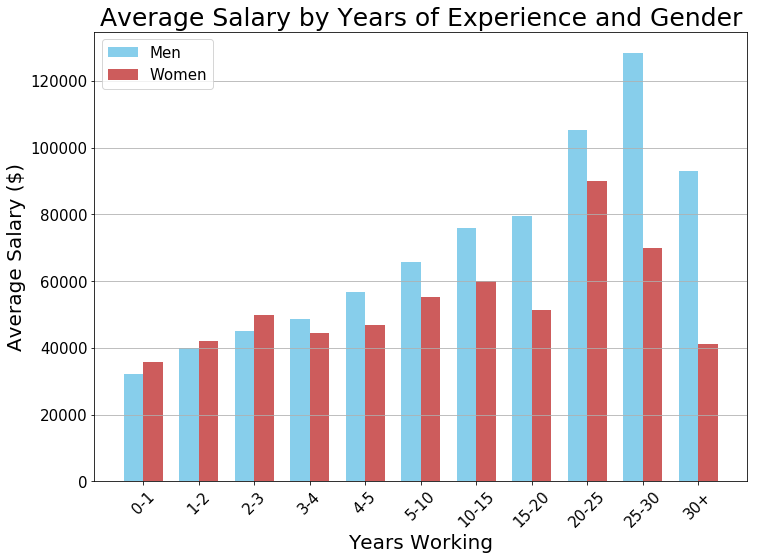

In [478]:
ind = np.arange(len(list(k_M.groupby(["Exp"]).Sal.mean())))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(11.7, 8.27))
rects1 = ax.bar(ind - width/2, list(k_M.groupby(["Exp"]).Sal.mean()), width,
                color='SkyBlue', label='Men')
rects2 = ax.bar(ind + width/2, list(k_F.groupby(["Exp"]).Sal.mean()), width,
                color='IndianRed', label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Salary ($)', fontsize = 20)
ax.set_xlabel('Years Working', fontsize = 20)
ax.set_title('Average Salary by Years of Experience and Gender', fontsize=25)
ax.set_xticks(ind)
ax.set_xticklabels(['0-1', '1-2', '2-3', '3-4','4-5','5-10', '10-15', '15-20', 
       '20-25','25-30', '30+'])
ax.tick_params(axis='x', labelsize = 15, labelrotation = 45)
ax.tick_params(axis='y', labelsize = 15)
ax.grid(True, axis="y")
ax.legend(fontsize= 15)

### Figure 2. Means and Medians per Preferred Programming Language

When considered together, two figures below can help us gain a better understanding of the principal tools used within the field by respondents from all salary brackets. 

First, we can see how **Python** and **R's** popularity accross all ends of the salary spectrum - which suggests they may not be useful salary predictor features. Each tool's median salary suggest most of their users receive around 30,000 to 40,000. 

Users of languages that are common in web development - like **PHP** and **Javascript/Typescript** - stand on the lower end of the spectrum. This may be due to how a developer's tools and professional track diverge from those of a data scientist after introductory-level roles. 

On the upper end, we can see the demand for big-data reflected by **Scala's** high median and mean salaries. Similarly, **SAS/STATA's** numbers may imply their continuous use even at executive-level or business-related positions. 

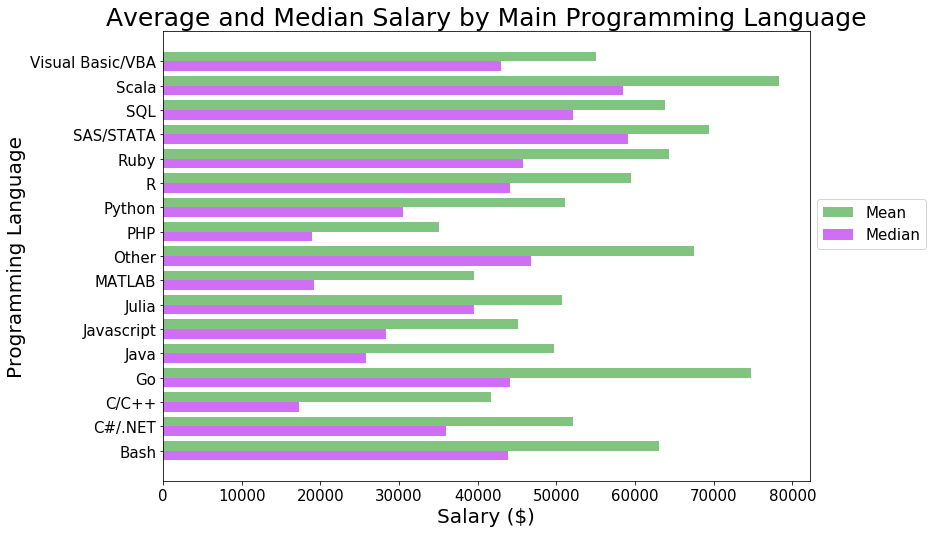

In [479]:
ind = np.arange(len(k_plot.groupby(["Q17"])))  # the x locations for the groups
width = 0.4  # the width of the bars

fig, ax_2 = plt.subplots(figsize=(11.7, 8.27))
rects1 = ax_2.barh(ind + width/2, list(k_plot.groupby(["Q17"]).Sal.mean()), width,
                color='#80C47F', label='Mean')
rects2 = ax_2.barh(ind - width/2, list(k_plot.groupby(["Q17"]).Sal.median()), width,
                color='#CF6FF3', label='Median')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_2.set_ylabel('Programming Language', fontsize=20)
ax_2.set_xlabel('Salary ($)', fontsize = 20)
plt.title('Average and Median Salary by Main Programming Language', fontsize=25)
#ax_2.set_title('Average and Median Salary by Main Programming Language')
ax_2.set_yticks(ind)
ax_2.set_yticklabels(["Bash","C#/.NET","C/C++", "Go", "Java","Javascript","Julia", "MATLAB",
                    "Other", "PHP", "Python", "R", "Ruby", "SAS/STATA", "SQL", "Scala", "Visual Basic/VBA"])
ax_2.tick_params(axis='y', labelsize = 15)
ax_2.tick_params(axis='x', labelsize = 15)
ax_2.grid(False, axis="y")

box = ax_2.get_position()
ax_2.set_position([box.x0, box.y0, box.width * .99, box.height])

# Put a legend to the right of the current axis
ax_2.legend(loc="lower left", bbox_to_anchor=(1, 0.5), fontsize=15)

plt.show()

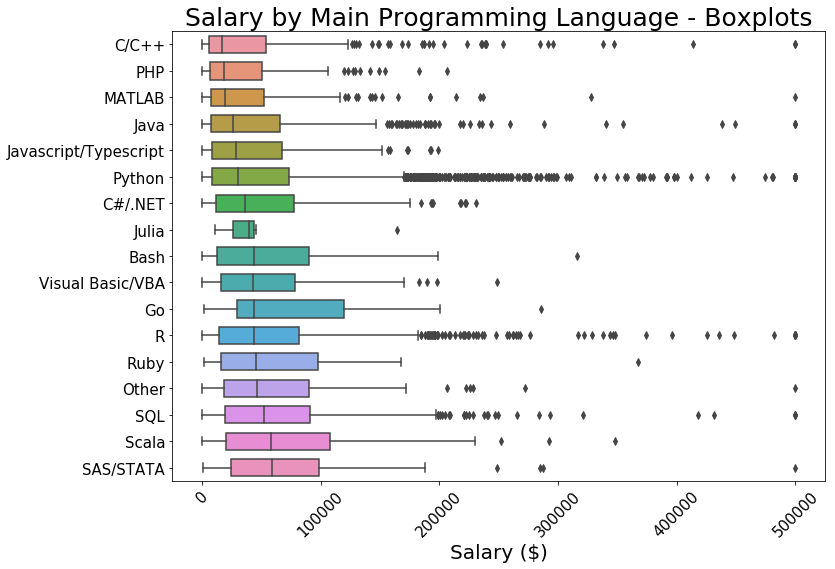

In [480]:
a4_dims = (11.7, 8.27)
fig, ax_3 = plt.subplots(figsize=a4_dims)

sns.boxplot(x=k_plot.Sal, y= k_plot["Q17"], data=k_plot, orient="h", width = 0.65, 
                 order=["C/C++","PHP","MATLAB","Java","Javascript/Typescript","Python","C#/.NET",
                        "Julia", "Bash", "Visual Basic/VBA",  "Go", "R", "Ruby",  "Other", 
                        "SQL", "Scala","SAS/STATA" ], ax=ax_3)

plt.title('Salary by Main Programming Language - Boxplots', fontsize=25)
ax_3.set_ylabel("")
ax_3.set_xlabel('Salary ($)', fontsize=20)
ax_3.tick_params(axis="x", labelsize = 15, labelrotation=45)
ax_3.tick_params(axis="y", labelsize = 15)

### Figure 3.  Average Salary by Occupation 

The figure offers a basis for a professional track in data science: 
1. **"Students"** and **"Research Assistant"** positions represent respondents who have yet to complete their degrees.
2. The next tier denotes entry-level, full-time job titles like **"Data Analyst"**. 
3. Then come titles that suggest a certain degree of financial specialization or business knowledge - **"Statistician", "Business Analyst", "Marketing Analyst"**. 
4. Those who specialize in data manipulation and modeling, can opt for **"Data Engineer"** and **"Data Scientist"** positions. 
5. Finally, we can see **managerial, consultancy and C-suite positions**. As expected, probably due to their need for many years of experience in the workforce, show the highest average salaries. 
    * Since it is unclear, it would be interesting to try to discover the different profiles encompassing **"Manager"** and **"Product/Project Manager"** positions; even though they sound similar in name, there are may be aspects of their experience, industries, tools or responsibilities that merit a difference in average salaryof around $20,000.

Text(0.5,1,'Average Salary by Occupation')

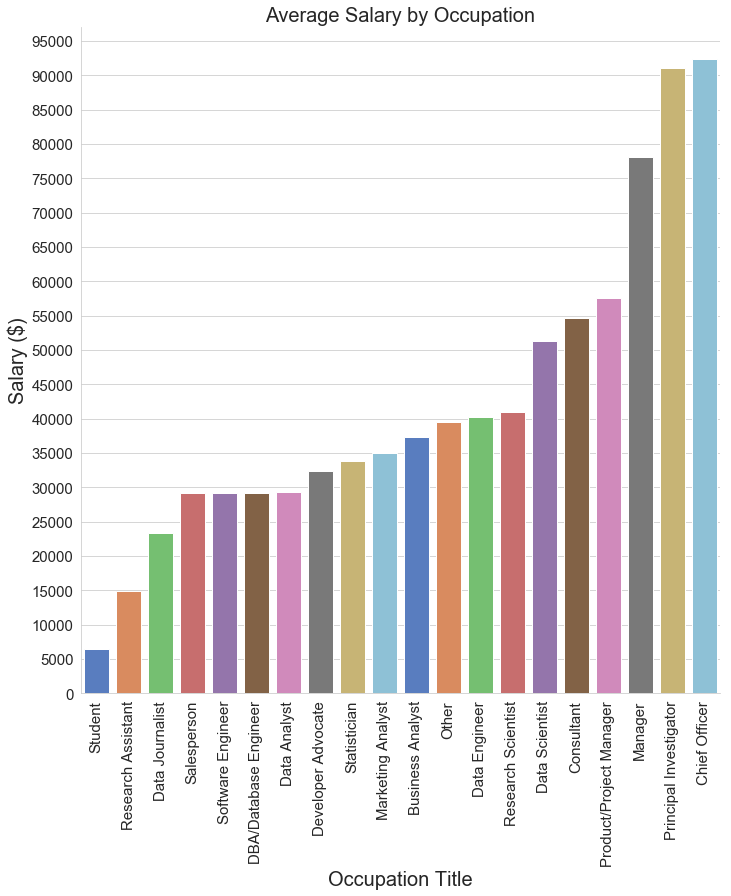

In [481]:
sns.set_style("whitegrid")
g = sns.catplot(x="Q6", y="Sal", data=k_plot, legend = True, ci = None,
                height=10, kind="bar", palette="muted", estimator=np.median,
                order = ['Student', 'Research Assistant','Data Journalist', 'Salesperson','Software Engineer', 
                          'DBA/Database Engineer', 'Data Analyst', 'Developer Advocate',
                         'Statistician', 'Marketing Analyst','Business Analyst', 'Other','Data Engineer',
                         'Research Scientist','Data Scientist', 'Consultant','Product/Project Manager',
                         'Manager', 'Principal Investigator',  'Chief Officer'])

g.set_xlabels("Occupation Title", fontsize = 20)
g.set_xticklabels(rotation=90, fontsize=15)
g.set(yticks=np.arange(0,95001,5000))
g.set_yticklabels(np.arange(0,95001,5000), fontsize=15)
g.set_ylabels("Salary ($)", fontsize = 20)
plt.title("Average Salary by Occupation", fontsize=20)

# 4. Data Cleaning

## 4.1 Feature Encoding

In [482]:
#Dictionary for Author's Reference Only

#Q11
Q_dict["Q11_Part_1"] = "Analyze and understand data to influence product or business decisions"
Q_dict["Q11_Part_2"] = "Build and/or run a machine learning service that operationally improves my product or workflows"
Q_dict["Q11_Part_3"] = "Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data"
Q_dict["Q11_Part_4"] = "Build prototypes to explore applying machine learning to new areas"
Q_dict["Q11_Part_5"] = "Do research that advances the state of the art of machine learning"
Q_dict["Q11_Part_6"] = "None of these activities are an important part of my role at work"

#Q13
Q_dict['Q13_Part_1'] = "IDE Used: Jupyter/IPython"
Q_dict['Q13_Part_2'] = "IDE Used: RStudio"
Q_dict["Q13_Part_3"] = "IDE Used: PyCharm"
Q_dict["Q13_Part_4"] = "IDE Used: Visual Studio Code"
Q_dict["Q13_Part_5"] = "IDE Used: nteract"
Q_dict["Q13_Part_6"] = "IDE Used: Atom"
Q_dict['Q13_Part_7'] = "IDE Used: MATLAB"
Q_dict['Q13_Part_8'] = "IDE Used: Visual Studio"
Q_dict["Q13_Part_9"] = "IDE Used: Notepad++"
Q_dict["Q13_Part_10"] = "IDE Used: Sublime Text"
Q_dict["Q13_Part_11"] = "IDE Used: Vim"
Q_dict["Q13_Part_12"] = "IDE Used: IntelliJ"
Q_dict["Q13_Part_13"] = "IDE Used: Spyder"
Q_dict["Q13_Part_14"] = "IDE Used: None"

#Q14
Q_dict['Q14_Part_1'] = "Hosted Notebooks Used: Kaggle Kernels"
Q_dict['Q14_Part_2'] = "Hosted Notebooks Used: Google Colab"
Q_dict["Q14_Part_3"] = "Hosted Notebooks Used: Azure Notebook"
Q_dict["Q14_Part_4"] = "Hosted Notebooks Used: Domino Datalab"
Q_dict["Q14_Part_5"] = "Hosted Notebooks Used: Google Cloud Datalab"
Q_dict["Q14_Part_6"] = "Hosted Notebooks Used: Paperspacen"
Q_dict['Q14_Part_7'] = "Hosted Notebooks Used: Floydhub"
Q_dict['Q14_Part_8'] = "Hosted Notebooks Used: Crestle"
Q_dict["Q14_Part_9"] = "Hosted Notebooks Used: JupyterHub"
Q_dict["Q14_Part_10"] = "Hosted Notebooks Used: None"

#Q15:
Q_dict['Q15_Part_1'] = "Cloud Computing Services Used: Google Cloud Platform"
Q_dict['Q15_Part_2'] = "Cloud Computing Services Used: Amazon Web Services"
Q_dict["Q15_Part_3"] = "Cloud Computing Services Used: Microsoft Azure"
Q_dict["Q15_Part_4"] = "Cloud Computing Services Used: IBM Cloud"
Q_dict["Q15_Part_5"] = "Cloud Computing Services Used: Alibaba Cloud"
Q_dict["Q15_Part_6"] = "Cloud Computing Services Used: No Cloud Providers"


#Q16:
Q_dict['Q16_Part_1'] = "Programming Languages Used: Python"
Q_dict['Q16_Part_2'] = "Programming Languages Used: R"
Q_dict["Q16_Part_3"] = "Programming Languages Used: SQL"
Q_dict["Q16_Part_4"] = "Programming Languages Used: Bash"
Q_dict["Q16_Part_5"] = "Programming Languages Used: Java"
Q_dict["Q16_Part_6"] = "Programming Languages Used: Javascript/Typescript"
Q_dict['Q16_Part_7'] = "Programming Languages Used: Visual Basic/VBA"
Q_dict['Q16_Part_8'] = "Programming Languages Used: C/C++"
Q_dict["Q16_Part_9"] = "Programming Languages Used: MATLAB"
Q_dict["Q16_Part_10"] = "Programming Languages Used: Scala"
Q_dict["Q16_Part_11"] = "Programming Languages Used: Julia"
Q_dict["Q16_Part_12"] = "Programming Languages Used: Go"
Q_dict["Q16_Part_13"] = "Programming Languages Used: Bash"
Q_dict["Q16_Part_14"] = "Programming Languages Used: C#/.NET"
Q_dict["Q16_Part_15"] = "Programming Languages Used: PHP"
Q_dict["Q16_Part_16"] = "Programming Languages Used: Ruby"
Q_dict["Q16_Part_17"] = "Programming Languages Used: SAS/STATA"


#Q19:
Q_dict['Q19_Part_1'] = "Machine Learning Framework Used: Sci-kit Learn"
Q_dict['Q19_Part_2'] = "Machine Learning Framework Used: TensorFlow"
Q_dict["Q19_Part_3"] = "Machine Learning Framework Used: Keras"
Q_dict["Q19_Part_4"] = "Machine Learning Framework Used: PyTorch"
Q_dict["Q19_Part_5"] = "Machine Learning Framework Used: Spark MLlib"
Q_dict["Q19_Part_6"] = "Machine Learning Framework Used: H20"
Q_dict['Q19_Part_7'] = "Machine Learning Framework Used: Fastai"
Q_dict['Q19_Part_8'] = "Machine Learning Framework Used: Mxnet"
Q_dict["Q19_Part_9"] = "Machine Learning Framework Used: Caret"
Q_dict["Q19_Part_10"] = "Machine Learning Framework Used: Xgboost"
Q_dict["Q19_Part_11"] = "Machine Learning Framework Used: mlr"
Q_dict["Q19_Part_12"] = "Machine Learning Framework Used: Prophet"
Q_dict["Q19_Part_13"] = "Machine Learning Framework Used: randomForest"
Q_dict["Q19_Part_14"] = "Machine Learning Framework Used: lightgbm"
Q_dict["Q19_Part_15"] = "Machine Learning Framework Used: catboost"
Q_dict["Q19_Part_16"] = "Machine Learning Framework Used: CNTK"
Q_dict["Q19_Part_17"] = "Machine Learning Framework Used: Caffe"
Q_dict["Q19_Part_18"] = "Machine Learning Framework Used: None"


#Q21: 
Q_dict['Q21_Part_1'] = "Data Viz Library Used: ggplot2"
Q_dict['Q21_Part_2'] = "Data Viz Library Used: Matplotlib"
Q_dict["Q21_Part_3"] = "Data Viz Library Used: Altair"
Q_dict["Q21_Part_4"] = "Data Viz Library Used: Shiny"
Q_dict["Q21_Part_5"] = "Data Viz Library Used: D3"
Q_dict["Q21_Part_6"] = "Data Viz Library Used: Plotly"
Q_dict['Q21_Part_7'] = "Data Viz Library Used: Bokeh"
Q_dict['Q21_Part_8'] = "Data Viz Library Used: Seaborn"
Q_dict["Q21_Part_9"] = "Data Viz Library Used: Geoplotlib"
Q_dict["Q21_Part_10"] = "Data Viz Library Used: Leaflet"
Q_dict["Q21_Part_11"] = "Data Viz Library Used: Lattice"
Q_dict["Q21_Part_12"] = "Data Viz Library Used: None"


#Q27: 
Q_dict['Q27_Part_1'] = "Cloud Computing Products Used: EC2"
Q_dict['Q27_Part_2'] = "Cloud Computing Products Used: Google Compute Engine"
Q_dict["Q27_Part_3"] = "Cloud Computing Products Used: AWS Elastic Beanstalk"
Q_dict["Q27_Part_4"] = "Cloud Computing Products Used: Google App Engine"
Q_dict["Q27_Part_5"] = "Cloud Computing Products Used: Google Kubernets Engine"
Q_dict["Q27_Part_6"] = "Cloud Computing Products Used: AWS Lambda"
Q_dict['Q27_Part_7'] = "Cloud Computing Products Used: Google Cloud Functions"
Q_dict['Q27_Part_8'] = "Cloud Computing Products Used: AWS Batch"
Q_dict["Q27_Part_9"] = "Cloud Computing Products Used: Azure Virtual Machines"
Q_dict["Q27_Part_10"] = "Cloud Computing Products Used: Azure Container Service"
Q_dict["Q27_Part_11"] = "Cloud Computing Products Used: Azure Functions"
Q_dict["Q27_Part_12"] = "Cloud Computing Products Used: Azure Event Grid"
Q_dict['Q27_Part_13'] = "Cloud Computing Products Used: Azure Batch"
Q_dict['Q27_Part_14'] = "Cloud Computing Products Used: Azure Kubernets Service"
Q_dict["Q27_Part_15"] = "Cloud Computing Products Used: IBM Cloud Virtual Servers"
Q_dict["Q27_Part_16"] = "Cloud Computing Products Used: IBM Cloud Container Registry"
Q_dict["Q27_Part_17"] = "Cloud Computing Products Used: IBM Cloud Kubernets Service"
Q_dict["Q27_Part_18"] = "Cloud Computing Products Used: IBM Cloud Foundry"
Q_dict['Q27_Part_19'] = "Cloud Computing Products Used: None"


#Q28:
Q_dict['Q28_Part_1'] = "ML Products Used: Amazon Transcribe"
Q_dict['Q28_Part_2'] = "ML Products Used: Google Cloud S-to-T API"
Q_dict["Q28_Part_3"] = "ML Products Used: Amazon Rekognition"
Q_dict["Q28_Part_4"] = "ML Products Used: Google Cloud Vision API"
Q_dict["Q28_Part_5"] = "ML Products Used: Amazon Comprehend"
Q_dict["Q28_Part_6"] = "ML Products Used: Google Cloud Natural Language API"
Q_dict['Q28_Part_7'] = "ML Products Used: Amazon Translate"
Q_dict['Q28_Part_8'] = "ML Products Used: Google Cloud Translation API"
Q_dict["Q28_Part_9"] = "ML Products Used: Amazon Lex"
Q_dict["Q28_Part_10"] = "ML Products Used: Google Cloud Dialogflow"
Q_dict["Q28_Part_11"] = "ML Products Used: Amazon Rekognition Video"
Q_dict["Q28_Part_12"] = "ML Products Used: Google Cloud Video Intelligence API"
Q_dict['Q28_Part_13'] = "ML Products Used: Google Cloud AutoML"
Q_dict['Q28_Part_14'] = "ML Products Used: Amazon Sagemaker"
Q_dict["Q28_Part_15"] = "ML Products Used: Google Cloud Machine Learning Engine"
Q_dict["Q28_Part_16"] = "ML Products Used: DataRobot"
Q_dict["Q28_Part_17"] = "ML Products Used: H20 Driverless AI"
Q_dict["Q28_Part_18"] = "ML Products Used: Domino DataLab"
Q_dict['Q28_Part_19'] = "ML Products Used: SAS"
Q_dict['Q28_Part_20'] = "ML Products Used: Dataiku"
Q_dict['Q28_Part_21'] = "ML Products Used: RapidMiner"
Q_dict["Q28_Part_22"] = "ML Products Used: Instabase"
Q_dict["Q28_Part_23"] = "ML Products Used: Algorithmia"
Q_dict["Q28_Part_24"] = "ML Products Used: Dataversity"
Q_dict["Q28_Part_25"] = "ML Products Used: Cloudera"
Q_dict['Q28_Part_26'] = "ML Products Used: Azure Machine Learning Studio"
Q_dict['Q28_Part_27'] = "ML Products Used: Azure Machine Learning Workbench"
Q_dict["Q28_Part_28"] = "ML Products Used: Azure Cortana Intelligence Suite"
Q_dict["Q28_Part_29"] = "ML Products Used: Azure Bing Speech"
Q_dict["Q28_Part_30"] = "ML Products Used: Azure Speaker Recognition"
Q_dict["Q28_Part_31"] = "ML Products Used: Azure Computer Vision"
Q_dict['Q28_Part_32'] = "ML Products Used: Azure Face"
Q_dict['Q28_Part_33'] = "ML Products Used: Azure Video"
Q_dict["Q28_Part_34"] = "ML Products Used: IBM Watson Studio"
Q_dict["Q28_Part_35"] = "ML Products Used: IBM Watson Knowledge Catalogue"
Q_dict["Q28_Part_36"] = "ML Products Used: IBM Watson Assistant"
Q_dict["Q28_Part_37"] = "ML Products Used: IBM Watson Discovery"
Q_dict['Q28_Part_38'] = "ML Products Used: IBM Watson T-to-S"
Q_dict["Q28_Part_39"] = "ML Products Used: IBM Watson Visual Recognition"
Q_dict["Q28_Part_40"] = "ML Products Used: IBM Watson Machine Learning"
Q_dict["Q28_Part_41"] = "ML Products Used: Azure Cognitive Services"
Q_dict["Q28_Part_42"] = "ML Products Used: None"

#Q29
Q_dict['Q29_Part_1'] = "Relational DB Used: AWS RDB"
Q_dict['Q29_Part_2'] = "Relational DB Used: AWS Aurora"
Q_dict["Q29_Part_3"] = "Relational DB Used: Google Cloud SQL"
Q_dict["Q29_Part_4"] = "Relational DB Used: Google Cloud Spanner"
Q_dict["Q29_Part_5"] = "Relational DB Used: AWS DynamoDB"
Q_dict["Q29_Part_6"] = "Relational DB Used: Google Cloud Datastore"
Q_dict['Q29_Part_7'] = "Relational DB Used: Google Cloud Bigtable"
Q_dict['Q29_Part_8'] = "Relational DB Used: AWS SimpleDB"
Q_dict["Q29_Part_9"] = "Relational DB Used: Microsoft SQL Server"
Q_dict["Q29_Part_10"] = "Relational DB Used: MySQL"
Q_dict["Q29_Part_11"] = "Relational DB Used: PostgresSQL"
Q_dict["Q29_Part_12"] = "Relational DB Used: SQLite"
Q_dict['Q29_Part_13'] = "Relational DB Used: Oracle Database"
Q_dict['Q29_Part_14'] = "Relational DB Used: Ingres"
Q_dict["Q29_Part_15"] = "Relational DB Used: Microsoft Access"
Q_dict["Q29_Part_16"] = "Relational DB Used: NexusDB"
Q_dict["Q29_Part_17"] = "Relational DB Used: SAP IQ"
Q_dict["Q29_Part_18"] = "Relational DB Used: Google Fusion Tables"
Q_dict['Q29_Part_19'] = "Relational DB Used: Azure Database for MySQL"
Q_dict['Q29_Part_20'] = "Relational DB Used: Cosmos DB"
Q_dict['Q29_Part_21'] = "Relational DB Used: Azure SQL DB"
Q_dict["Q29_Part_22"] = "Relational DB Used: Azure Database for PostgresSQL"
Q_dict["Q29_Part_23"] = "Relational DB Used: IBM Cloud Compose"
Q_dict["Q29_Part_24"] = "Relational DB Used: IBM Cloud Compose for MySQL"
Q_dict["Q29_Part_25"] = "Relational DB Used: IBM Cloud Compose for PostgresSQL"
Q_dict['Q29_Part_26'] = "Relational DB Used: IBM Cloud DB2"
Q_dict['Q29_Part_27'] = "Relational DB Used: None"


#Q30
Q_dict['Q30_Part_1'] = "Big Data Product Used: AWS Elastic MapReduce"
Q_dict['Q30_Part_2'] = "Big Data Product Used: AWS Batch"
Q_dict["Q30_Part_3"] = "Big Data Product Used: Google Cloud Dataproc"
Q_dict["Q30_Part_4"] = "Big Data Product Used: Google Cloud Dataflow"
Q_dict["Q30_Part_5"] = "Big Data Product Used: Google Cloud Dataprep"
Q_dict["Q30_Part_6"] = "Big Data Product Used: AWS Kinesis"
Q_dict['Q30_Part_7'] = "Big Data Product Used: Google Cloud Pub/Sub"
Q_dict['Q30_Part_8'] = "Big Data Product Used: AWS Athena"
Q_dict["Q30_Part_9"] = "Big Data Product Used: AWS Redshift"
Q_dict["Q30_Part_10"] = "Big Data Product Used: Google BigQuery"
Q_dict["Q30_Part_11"] = "Big Data Product Used: Teradata"
Q_dict["Q30_Part_12"] = "Big Data Product Used: Microsoft Analysis Services"
Q_dict['Q30_Part_13'] = "Big Data Product Used: Oracle Exadata"
Q_dict['Q30_Part_14'] = "Big Data Product Used: Oracle Warehouse Builder"
Q_dict["Q30_Part_15"] = "Big Data Product Used: SAP IQ"
Q_dict["Q30_Part_16"] = "Big Data Product Used: Snowflake"
Q_dict["Q30_Part_17"] = "Big Data Product Used: Databricks"
Q_dict["Q30_Part_18"] = "Big Data Product Used: Azure SQL Data Warehouse"
Q_dict['Q30_Part_19'] = "Big Data Product Used: Azure HDInsight"
Q_dict['Q30_Part_20'] = "Big Data Product Used: Azure Stream Analytics"
Q_dict['Q30_Part_21'] = "Big Data Product Used: IBM Infosphre Data Storage"
Q_dict["Q30_Part_22"] = "Big Data Product Used: IBM Cloud Analytics Engine"
Q_dict["Q30_Part_23"] = "Big Data Product Used: IBM Cloud Streaming Analytic"
Q_dict["Q30_Part_24"] = "Big Data Product Used: None"


#Q31
Q_dict['Q31_Part_1'] = "Data Type Used: Audio"
Q_dict['Q31_Part_2'] = "Data Type Used: Categorical"
Q_dict["Q31_Part_3"] = "Data Type Used: Genetic"
Q_dict["Q31_Part_4"] = "Data Type Used: Geospatial"
Q_dict["Q31_Part_5"] = "Data Type Used: Image"
Q_dict["Q31_Part_6"] = "Data Type Used: Numerical"
Q_dict['Q31_Part_7'] = "Data Type Used: Sensor"
Q_dict['Q31_Part_8'] = "Data Type Used: Tabular"
Q_dict["Q31_Part_9"] = "Data Type Used: Text"
Q_dict["Q31_Part_10"] = "Data Type Used: Time Series"
Q_dict["Q31_Part_11"] = "Data Type Used: Video"
Q_dict["Q31_Part_12"] = "Data Type Used: Other"


#Q33
Q_dict['Q33_Part_1'] = "Public Data Source: Government"
Q_dict['Q33_Part_2'] = "Public Data Source: University Research Groups"
Q_dict["Q33_Part_3"] = "Public Data Source: Non-Profit Research Groups"
Q_dict["Q33_Part_4"] = "Public Data Source: Dataset Aggregator"
Q_dict["Q33_Part_5"] = "Public Data Source: Collect My Own"
Q_dict["Q33_Part_6"] = "Public Data Source: Publicly Released from Private Companies"
Q_dict["Q33_Part_7"] = "Public Data Source: Google Search"
Q_dict["Q33_Part_8"] = "Public Data Source:: Google Dataset Search"
Q_dict["Q33_Part_9"] = "Public Data Source: GitHub"
Q_dict["Q33_Part_10"] = "Public Data Source: None"


#Q36
Q_dict['Q36_Part_1'] = "Online Platform: Udacity"
Q_dict['Q36_Part_2'] = "Online Platform: Coursera"
Q_dict["Q36_Part_3"] = "Online Platform: edX"
Q_dict["Q36_Part_4"] = "Online Platform: Datacamp"
Q_dict["Q36_Part_5"] = "Online Platform: DataQuest"
Q_dict["Q36_Part_6"] = "Online Platform: Kaggle Learn"
Q_dict['Q36_Part_7'] = "Online Platform: Fast.AI"
Q_dict['Q36_Part_8'] = "Online Platform: developers.google.com"
Q_dict["Q36_Part_9"] = "Online Platform: Udemy"
Q_dict["Q36_Part_10"] = "Online Platform: TheSchool.AI"
Q_dict["Q36_Part_11"] = "Online Platform: Online University Courses"
Q_dict["Q36_Part_12"] = "Data Type Used: None"

#Q42
Q_dict['Q42_Part_1'] = "Metrics for Models: Revenue/Business Goals"
Q_dict['Q42_Part_2'] = "Online Platform: Accurarcy"
Q_dict["Q42_Part_3"] = "Online Platform: Unfair Bias"
Q_dict["Q42_Part_4"] = "Online Platform: N/A"


#Q45
Q_dict['Q45_Part_1'] = "Explore Insights: Very Important Models"
Q_dict['Q45_Part_2'] = "Explore Insights: All Models Before Production"
Q_dict["Q45_Part_3"] = "Explore Insights: Determining Model Worth"
Q_dict["Q45_Part_4"] = "Explore Insights: Model for Specific Insights"
Q_dict["Q45_Part_5"] = "Explore Insights: Exploring New Model/Data"
Q_dict["Q45_Part_6"] = "Explore Insights: Does Not Explore New Models"

#Q47
Q_dict['Q47_Part_1'] = "Interpretation: Individual Model Coefficients"
Q_dict['Q47_Part_2'] = "Interpretation: Feature Correlation"
Q_dict["Q47_Part_3"] = "Interpretation: Feature Importance"
Q_dict["Q47_Part_4"] = "Interpretation: Plot Decision Boundaries"
Q_dict["Q47_Part_5"] = "Interpretation: Partial Dependence Plots"
Q_dict["Q47_Part_6"] = "Interpretation: Dimensionality Reduction"
Q_dict['Q47_Part_7'] = "Interpretation: Attention/Saliency Mapping"
Q_dict['Q47_Part_8'] = "Interpretation: Plot Predicted v. Actual Results"
Q_dict["Q47_Part_9"] = "Interpretation: Decision Trees"
Q_dict["Q47_Part_10"] = "Interpretation: Sensitivity Analysis"
Q_dict["Q47_Part_11"] = "Interpretation: LIME Functions"
Q_dict["Q47_Part_12"] = "Interpretation: ELI5 Functions"
Q_dict['Q47_Part_13'] = "Interpretation: SHAP Functions"
Q_dict['Q47_Part_14'] = "Interpretation: None"


#Q49
Q_dict['Q49_Part_1'] = "Reproduce Work: Code on GitHub/Code-Sharing Repository"
Q_dict['Q49_Part_2'] = "Reproduce Work: Code and Data on GitHub/Code-Sharing Repository"
Q_dict["Q49_Part_3"] = "Reproduce Work: Code, Data, Env on hosted service"
Q_dict["Q49_Part_4"] = "Reproduce Work: Code, Data, Env on containers"
Q_dict["Q49_Part_5"] = "Reproduce Work: Code, Data, Env on virtual machines"
Q_dict["Q49_Part_6"] = "Reproduce Work: Well-documented Code"
Q_dict['Q49_Part_7'] = "Reproduce Work: Human-readable Code"
Q_dict['Q49_Part_8'] = "Reproduce Work: Define Random Seeds"
Q_dict["Q49_Part_9"] = "Reproduce Work: Relative File Paths"
Q_dict["Q49_Part_10"] = "Reproduce Work: Dependencies Text File"
Q_dict["Q49_Part_11"] = "Reproduce Work: None"


#Q50
Q_dict['Q50_Part_1'] = "Barriers to Reproduction: Expensive"
Q_dict['Q50_Part_2'] = "Barriers to Reproduction: Time-Consuming"
Q_dict["Q50_Part_3"] = "Barriers to Reproduction: Technical Knowledge"
Q_dict["Q50_Part_4"] = "Barriers to Reproduction: Potential Lack of Crediting"
Q_dict["Q50_Part_5"] = "Barriers to Reproduction: No Incentives"
Q_dict["Q50_Part_6"] = "Barriers to Reproduction: Had not considered"
Q_dict['Q50_Part_7'] = "Reproduce Work: None"


In [483]:
#Define columns that will not be used in the main section of the analysis
drop_cols = ["Unnamed: 0", "Time from Start to Finish (seconds)", "Q38_Part_1", "Q38_Part_2", "Q38_Part_3",
            "Q38_Part_4", "Q38_Part_5", "Q38_Part_6", "Q38_Part_7", "Q38_Part_8", "Q38_Part_9",
             "Q38_Part_10", "Q38_Part_11", "Q38_Part_12", "Q38_Part_13", "Q38_Part_14", "Q38_Part_15",
            "Q38_Part_16", "Q38_Part_17", "Q38_Part_18", "Q38_Part_19", "Q38_Part_20", "Q38_Part_21",
            "Q38_Part_22", "Q39_Part_1", "Q39_Part_2", "Q41_Part_1", "Q41_Part_2", "Q41_Part_3"]

redundant_q_cols = ["Q17", "Q20", "Q22", "Q33_Part_6", "Q33_Part_7", "Q33_Part_8", "Q33_Part_9", 
                    "Q37", "Q40"]

other_text_cols = ["Q1_OTHER_TEXT","Q6_OTHER_TEXT", "Q7_OTHER_TEXT", "Q11_Part_7", "Q11_OTHER_TEXT", 
                   'Q12_Part_1_TEXT', 'Q12_Part_2_TEXT', 'Q12_Part_3_TEXT', 'Q12_Part_4_TEXT', 
                   'Q12_Part_5_TEXT', 'Q12_OTHER_TEXT', 'Q13_Part_15', "Q13_OTHER_TEXT", 'Q14_Part_11', 
                   'Q14_OTHER_TEXT','Q15_Part_7', 'Q15_OTHER_TEXT', 'Q16_Part_18', 'Q16_OTHER_TEXT', 
                   "Q17_OTHER_TEXT",'Q18','Q18_OTHER_TEXT', "Q19_Part_19", "Q19_OTHER_TEXT",
                   'Q20_OTHER_TEXT', 'Q21_Part_13', 'Q21_OTHER_TEXT','Q22_OTHER_TEXT', 
                   "Q27_Part_20", "Q27_OTHER_TEXT", "Q28_Part_43", "Q28_OTHER_TEXT", 
                   "Q29_Part_28", "Q29_OTHER_TEXT", "Q30_Part_25", "Q30_OTHER_TEXT", "Q31_OTHER_TEXT", 
                  "Q32_OTHER", "Q33_Part_11", "Q33_OTHER_TEXT", "Q34_OTHER_TEXT", "Q35_OTHER_TEXT", 
                  "Q36_Part_13", "Q36_OTHER_TEXT", "Q37_OTHER_TEXT", "Q38_OTHER_TEXT", "Q42_Part_5", 
                  "Q42_OTHER_TEXT", "Q44_Part_1", "Q44_Part_2", "Q44_Part_3", "Q44_Part_4", "Q44_Part_5", 
                  "Q44_Part_6", "Q47_Part_15", "Q47_Part_16", "Q49_Part_12", "Q49_OTHER_TEXT", "Q50_Part_8",
                  "Q50_OTHER_TEXT"]

k_df = k_df.drop(drop_cols, axis=1)

Now we will apply the logic described in Section 2.1 to encode or transform the features below. 

In [484]:
#Q1:
#Drop Q1 other responses and Q1_OTHER_TEXT: only 0.01% do not describe themselves as Male or Female
k_df = k_df.drop(k_df[(k_df.Q1 == "Prefer not to say") | (k_df.Q1 == "Prefer to self-describe")].index)

#Turn column to binary - 1 for Male, 0 for Female
k_df["Q1"] = k_df["Q1"].apply(lambda x: 1 if x == "Male" else 0)

#Q2: 
k_df["Q2"] = k_df["Q2"].apply(convert_Age)

#Q3: 
k_df["Q3"] = k_df["Q3"].apply(country_to_Continent)

#Q4: 
k_df["Q4"] = k_df["Q4"].apply(convert_Degree)

#Q5: 
k_df.loc[k_df['Q5'].isnull(), 'Q5'] = 'I never declared a major'

#Q8: 
k_df["Q8"] = k_df["Q8"].apply(convert_Experience)

#Q9: From Object to Numeric
k_df["Q9"] = k_df["Q9"].apply(pd.to_numeric)

#Q10: 
k_df["Q10"] = k_df["Q10"].apply(ml_Work)

#Q11: CHANGE Column Entry in Reference Dict, turn data into dummies
Q11_cols = ["Q11_Part_1", "Q11_Part_2", "Q11_Part_3", "Q11_Part_4", "Q11_Part_5", "Q11_Part_6"]

cols_Dummies(Q11_cols)

#Q12: Fill NaN entries with mode
k_df['Q12_MULTIPLE_CHOICE'].fillna(k_df['Q12_MULTIPLE_CHOICE'].mode()[0],inplace=True)

#Q13: Turn data into dummies
Q13_cols = ['Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_5', 'Q13_Part_6', 
           'Q13_Part_7', 'Q13_Part_8', 'Q13_Part_9', 'Q13_Part_10', 'Q13_Part_11', 'Q13_Part_12',
           'Q13_Part_13', 'Q13_Part_14']

cols_Dummies(Q13_cols)

#Q14: Turn data into dummies
Q14_cols = ['Q14_Part_1', 'Q14_Part_2', 'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_6', 
           'Q14_Part_7', 'Q14_Part_8', 'Q14_Part_9', 'Q14_Part_10']

cols_Dummies(Q14_cols)

#Q15: Turn data into dummies
Q15_cols = ['Q15_Part_1', 'Q15_Part_2', 'Q15_Part_3', 'Q15_Part_4', 'Q15_Part_5', 'Q15_Part_6']

cols_Dummies(Q15_cols)

#Q16: CHANGE Column Entry in Reference Dict, turn data into dummies
Q16_cols = ['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5', 'Q16_Part_6',
           'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10', 'Q16_Part_11', 'Q16_Part_12', 
           'Q16_Part_13', 'Q16_Part_14', 'Q16_Part_15', 'Q16_Part_16', 'Q16_Part_17']

cols_Dummies(Q16_cols)

#Q19: Turn data into dummies
Q19_cols = ['Q19_Part_1', 'Q19_Part_2', 'Q19_Part_3', 'Q19_Part_4', 'Q19_Part_5', 'Q19_Part_6',
           'Q19_Part_7', 'Q19_Part_8', 'Q19_Part_9', 'Q19_Part_10', 'Q19_Part_11', 'Q19_Part_12', 
           'Q19_Part_13', 'Q19_Part_14', 'Q19_Part_15', 'Q19_Part_16', 'Q19_Part_17', 'Q19_Part_18']

cols_Dummies(Q19_cols)

#Q21:Turn data into dummies
Q21_cols = ['Q21_Part_1', 'Q21_Part_2', 'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5', 'Q21_Part_6',
           'Q21_Part_7', 'Q21_Part_8', 'Q21_Part_9', 'Q21_Part_10', 'Q21_Part_11', 'Q21_Part_12'] 

cols_Dummies(Q21_cols)

#Q22: 
k_df.loc[k_df['Q22'].isnull(), 'Q22'] = 'None'

#Q23: 
k_df["Q23"] = k_df["Q23"].apply(convert_Time_Coding)

#Q24:
k_df["Q24"] = k_df["Q24"].apply(convert_Time_Analyzing)

#Q25: 
k_df["Q25"] = k_df["Q25"].apply(convert_Time_ML)

#Q26: 
k_df["Q26"] = k_df["Q26"].apply(convert_Likert)

#Q27: Turn data into dummies
Q27_cols = ['Q27_Part_1', 'Q27_Part_2', 'Q27_Part_3', 'Q27_Part_4', 'Q27_Part_5', 'Q27_Part_6',
           'Q27_Part_7', 'Q27_Part_8', 'Q27_Part_9', 'Q27_Part_10', 'Q27_Part_11', 'Q27_Part_12',
           'Q27_Part_13', 'Q27_Part_14', 'Q27_Part_15', 'Q27_Part_16', 'Q27_Part_17', 'Q27_Part_18',
            'Q27_Part_19'] 

cols_Dummies(Q27_cols)

#Q28: Compile available questions into categories, turn data into an "added dummy" for each category
Q28_AMZ_cols = ['Q28_Part_1', 'Q28_Part_3', 'Q28_Part_5', 'Q28_Part_7', 'Q28_Part_9',
           'Q28_Part_11', 'Q28_Part_14']

Q28_GLE_cols = ['Q28_Part_2', 'Q28_Part_4', 'Q28_Part_6', 'Q28_Part_8', 'Q28_Part_10',
           'Q28_Part_12', 'Q28_Part_13', 'Q28_Part_15']

Q28_OTHR_cols = ['Q28_Part_16', 'Q28_Part_17', 'Q28_Part_18', 'Q28_Part_19', 'Q28_Part_20',
           'Q28_Part_21', 'Q28_Part_22','Q28_Part_23', 'Q28_Part_24','Q28_Part_25']

Q28_AZR_cols = ['Q28_Part_26', 'Q28_Part_27', 'Q28_Part_28', 'Q28_Part_29', 'Q28_Part_30',
           'Q28_Part_31', 'Q28_Part_32','Q28_Part_33','Q28_Part_41']

Q28_IBM_cols = ['Q28_Part_34', 'Q28_Part_35', 'Q28_Part_36', 'Q28_Part_37', 'Q28_Part_38',
           'Q28_Part_39', 'Q28_Part_40']

Q_dict['Q28_AMZ'] = "ML Products Used: AMAZON"
k_df['Q28_AMZ'] = cols_Added_Dummies(Q28_AMZ_cols)
k_df = k_df.drop(Q28_AMZ_cols, axis=1)

Q_dict['Q28_GLE'] = "ML Products Used: GOOGLE"
k_df['Q28_GLE'] = cols_Added_Dummies(Q28_GLE_cols)
k_df = k_df.drop(Q28_GLE_cols, axis=1)

Q_dict["Q28_OTHR"] = "ML Products Used: OTHERS"
k_df['Q28_OTHR'] = cols_Added_Dummies(Q28_OTHR_cols)
k_df = k_df.drop(Q28_OTHR_cols, axis=1)

Q_dict["Q28_AZR"] = "ML Products Used: AZURE"
k_df['Q28_AZR'] = cols_Added_Dummies(Q28_AZR_cols)
k_df = k_df.drop(Q28_AZR_cols, axis=1)

Q_dict["Q28_IBM"] = "ML Products Used: IBM"
k_df['Q28_IBM'] = cols_Added_Dummies(Q28_IBM_cols)
k_df = k_df.drop(Q28_IBM_cols, axis=1)

Q_dict["Q28_Part_6"] = "ML Products Used: None"
k_df['Q28_NONE'] = pd.get_dummies(data=k_df, columns=["Q28_Part_42"]).iloc[:, -1]
k_df = k_df.drop("Q28_Part_42", axis=1)

#Q29: Turn data into dummies
Q29_cols = ['Q29_Part_1', 'Q29_Part_2', 'Q29_Part_3', 'Q29_Part_4', 'Q29_Part_5', 'Q29_Part_6',
           'Q29_Part_7', 'Q29_Part_8', 'Q29_Part_9', 'Q29_Part_10', 'Q29_Part_11', 'Q29_Part_12',
           'Q29_Part_13', 'Q29_Part_14', 'Q29_Part_15', 'Q29_Part_16', 'Q29_Part_17', 'Q29_Part_18',
            'Q29_Part_19', 'Q29_Part_20', 'Q29_Part_21', 'Q29_Part_22', 'Q29_Part_23','Q29_Part_24', 
            'Q29_Part_25', 'Q29_Part_26', 'Q29_Part_27'] 

cols_Dummies(Q29_cols)

#Q30: Turn data into dummies
Q30_cols = ['Q30_Part_1', 'Q30_Part_2', 'Q30_Part_3', 'Q30_Part_4', 'Q30_Part_5', 'Q30_Part_6',
           'Q30_Part_7', 'Q30_Part_8', 'Q30_Part_9', 'Q30_Part_10', 'Q30_Part_11', 'Q30_Part_12',
           'Q30_Part_13', 'Q30_Part_14', 'Q30_Part_15', 'Q30_Part_16', 'Q30_Part_17', 'Q30_Part_18',
            'Q30_Part_19', 'Q30_Part_20', 'Q30_Part_21', 'Q30_Part_22', 'Q30_Part_23','Q30_Part_24'] 

cols_Dummies(Q30_cols)

#Q31: Turn data into dummies
Q31_cols = ['Q31_Part_1', 'Q31_Part_2', 'Q31_Part_3', 'Q31_Part_4', 'Q31_Part_5', 'Q31_Part_6',
           'Q31_Part_7', 'Q31_Part_8', 'Q31_Part_9', 'Q31_Part_10', 'Q31_Part_11', 'Q31_Part_12'] 

cols_Dummies(Q31_cols)

#Q33: Categorize features according to source of data, then turn categories into "added dummies"
Q33_PUB_cols = ['Q33_Part_1', 'Q33_Part_2', 'Q33_Part_3', 'Q33_Part_4', 'Q31_Part_6',
           'Q31_Part_7', 'Q31_Part_8', 'Q31_Part_9']

Q_dict["Q33_Part_1"] = "Packaged Public Data"
k_df['Q33_Part_1'] = cols_Added_Dummies(Q33_PUB_cols)
k_df = k_df.drop(Q33_PUB_cols, axis=1)

k_df["Q33_Part_5"] = pd.get_dummies(data=k_df, columns=["Q33_Part_5"]).iloc[:, -1]

k_df["Q33_Part_10"] = pd.get_dummies(data=k_df, columns=["Q33_Part_10"]).iloc[:, -1]

#Q34: CHANGE Str to Floats; make NaNs into median
k_df["Q34_Part_1"] = k_df["Q34_Part_1"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_1"].fillna(k_df["Q34_Part_1"].mode()[0],inplace=True)

k_df["Q34_Part_2"] = k_df["Q34_Part_2"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_2"].fillna(k_df["Q34_Part_2"].mode()[0],inplace=True)

k_df["Q34_Part_3"] = k_df["Q34_Part_3"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_3"].fillna(k_df["Q34_Part_3"].mode()[0],inplace=True)

k_df["Q34_Part_4"] = k_df["Q34_Part_4"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_4"].fillna(k_df["Q34_Part_4"].mode()[0],inplace=True)

k_df["Q34_Part_5"] = k_df["Q34_Part_5"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_5"].fillna(k_df["Q34_Part_5"].mode()[0],inplace=True)

k_df["Q34_Part_6"] = k_df["Q34_Part_6"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q34_Part_6"].fillna(k_df["Q34_Part_6"].mode()[0],inplace=True)

#Q35: CHANGE Str to Floats; make NaNs into median
k_df["Q35_Part_1"] = k_df["Q35_Part_1"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_1"].fillna(k_df["Q35_Part_1"].mode()[0],inplace=True)

k_df["Q35_Part_2"] = k_df["Q35_Part_2"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_2"].fillna(k_df["Q35_Part_2"].mode()[0],inplace=True)

k_df["Q35_Part_3"] = k_df["Q35_Part_3"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_3"].fillna(k_df["Q35_Part_3"].mode()[0],inplace=True)

k_df["Q35_Part_4"] = k_df["Q35_Part_4"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_4"].fillna(k_df["Q35_Part_4"].mode()[0],inplace=True)

k_df["Q35_Part_5"] = k_df["Q35_Part_5"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_5"].fillna(k_df["Q35_Part_5"].mode()[0],inplace=True)

k_df["Q35_Part_6"] = k_df["Q35_Part_6"].apply(lambda x: float(x) if type(x) == str else x)
k_df["Q35_Part_6"].fillna(k_df["Q35_Part_6"].mode()[0],inplace=True)


#Q36: Turn data into dummies
Q36_cols = ['Q36_Part_1', 'Q36_Part_2', 'Q36_Part_3', 'Q36_Part_4', 'Q36_Part_5', 'Q36_Part_6',
           'Q36_Part_7', 'Q36_Part_8', 'Q36_Part_9', 'Q36_Part_10', 'Q36_Part_11', 'Q36_Part_12'] 

cols_Dummies(Q36_cols)

#Q42: Turn data into dummies
Q42_cols = ['Q42_Part_1', 'Q42_Part_2', 'Q42_Part_3', 'Q42_Part_4']

cols_Dummies(Q42_cols)

#Q43: 
k_df["Q43"] = k_df["Q43"].apply(convert_UnfairBias)

#Q45: Turn data into dummies
Q45_cols = ['Q45_Part_1', 'Q45_Part_2', 'Q45_Part_3', 'Q45_Part_4','Q45_Part_5', 'Q45_Part_6']

cols_Dummies(Q45_cols)

#Q46: 
k_df["Q46"] = k_df["Q46"].apply(convert_UnfairBias)


#Q47: Turn data into dummies
Q47_cols = ['Q47_Part_1', 'Q47_Part_2', 'Q47_Part_3', 'Q47_Part_4', 'Q47_Part_5', 'Q47_Part_6',
           'Q47_Part_7', 'Q47_Part_8', 'Q47_Part_9', 'Q47_Part_10', 'Q47_Part_11', 'Q47_Part_12', 
           'Q47_Part_13', 'Q47_Part_14'] 

cols_Dummies(Q47_cols)

#Q48: 
k_df["Q48"] = k_df["Q48"].apply(model_Blackbox)

#Q49: Turn data into dummies
Q49_cols = ['Q49_Part_1', 'Q49_Part_2', 'Q49_Part_3', 'Q49_Part_4', 'Q49_Part_5', 'Q49_Part_6',
           'Q49_Part_7', 'Q49_Part_8', 'Q49_Part_9', 'Q49_Part_10', 'Q49_Part_11'] 

cols_Dummies(Q49_cols)


#Q50: Turn data into dummies
Q50_cols = ['Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3', 'Q50_Part_4', 'Q50_Part_5', 'Q50_Part_6',
           'Q50_Part_7'] 

cols_Dummies(Q50_cols)

In [485]:
#Drop columns that are either redundant or which were needed only for the transformations above
k_df = k_df.drop(other_text_cols, axis=1)
k_df = k_df.drop(redundant_q_cols, axis=1)

In [486]:
#Turn last categorical features into dummies
k_dummies = pd.get_dummies(data=k_df, columns=["Q3", "Q5", "Q6", "Q7", "Q12_MULTIPLE_CHOICE", "Q32"])

#k_dummies.to_csv("k_dummies.csv")

# 5. Feature Selection
Feature selection is a useful tool for machine learning because:
1. ...it decreases the number of available features and so makes it easier to navigate datasets.
2. ...it prevents overfitting.
3. ... it can potentially improve accuracy by removing features that have little correlation to our target variable.
4. ... and it reduces training time, thereby giving us more time to train and experiment with different algorithms. 

For the present analysis, we will use Recursive Feature Selection paired with Cross-Validation (RFECV). Like Recursive Feature Selection, RFECV will assign weights to features based on a specified estimator. Said estimator will be trained on the initial set of features and the importance of each feature is derived from metrics such Mean Absolute Error or R^2. With each iteration, RFE will remove "unimportant" features until it only keeps the desired number of features. 

With Cross-Validation included, RFECV will go through multiple folds and calculate the importance of individual features in each instance. Those features that received the highest ranks the most often are expected to do best in the overall model.

Since we are trying to determine the correlation between features and salaries, we have selected Linear Regression as the RFECV estimator and selected R^2 as the score used to rank the columns. We have also arbitrarily decided to use the 50 features with the highest overall ranks. 

## 5.1 Split Data - Train & Test Subsets

In [487]:
k_Train,k_Test = train_test_split(k_dummies,test_size=0.33, random_state=17)

In [488]:
k_Y = k_Train['Q9']
k_X = k_Train.drop(['Q9'], axis=1)

k_Y_Test = k_Test['Q9']
k_X_Test = k_Test.drop(['Q9'], axis=1)

## 5.2 Recursive Feature Selection with Cross Validation

In [452]:
linear_R = LinearRegression()
rfecv = RFECV(linear_R, cv=10, scoring="r2")
fit = rfecv.fit(k_X[1:10000], k_Y[1:10000])

rfecv_l = [x[1] for x in sorted(list(zip(fit.ranking_, k_X)))[0:50]]

In [489]:
k_dummies[rfecv_l].columns

Index(['Q6_Principal Investigator', 'Q21_Part_11', 'Q27_Part_13', 'Q27_Part_3',
       'Q32_Sensor Data', 'Q3_NA', 'Q6_Student', 'Q6_Consultant',
       'Q7_Government/Public Service', 'Q45_Part_3', 'Q31_Part_3',
       'Q36_Part_10', 'Q29_Part_20', 'Q47_Part_2', 'Q30_Part_18',
       'Q19_Part_16', 'Q47_Part_6', 'Q19_Part_8', 'Q7_Energy/Mining',
       'Q11_Part_2', 'Q1', 'Q47_Part_7', 'Q6_Data Analyst', 'Q29_Part_27',
       'Q16_Part_3', 'Q5_I never declared a major', 'Q29_Part_12', 'Q7_Other',
       'Q19_Part_4', 'Q27_Part_15', 'Q30_Part_10', 'Q27_Part_2', 'Q31_Part_5',
       'Q16_Part_12', 'Q42_Part_2', 'Q29_Part_15', 'Q29_Part_9', 'Q42_Part_3',
       'Q36_Part_3', 'Q31_Part_1', 'Q32_Categorical Data',
       'Q7_Medical/Pharmaceutical', 'Q6_Research Assistant', 'Q19_Part_2',
       'Q30_Part_3', 'Q27_Part_5', 'Q50_Part_3',
       'Q7_Insurance/Risk Assessment', 'Q49_Part_6', 'Q36_Part_12'],
      dtype='object')

## Figure 4.  Correlation Matrix with RFECV Features
The figure below shows the correlation scores for the top-50 features (plus Salary, represented by the header "Q9"). Interestingly, many of our features show a low correlation with salary. The one notable exception is "Q3_NA", which marks respondents from North America - the US, Canada or Mexico. This is probably due to the relatively high salaries of the American workforce compared to the rest of the world. (We should not discount the possibility that the correlation is stronger due to the very large amount of American respondents.)

In [490]:
corr_l = rfe_l + ["Q9"]
k_corr = k_dummies[corr_l]

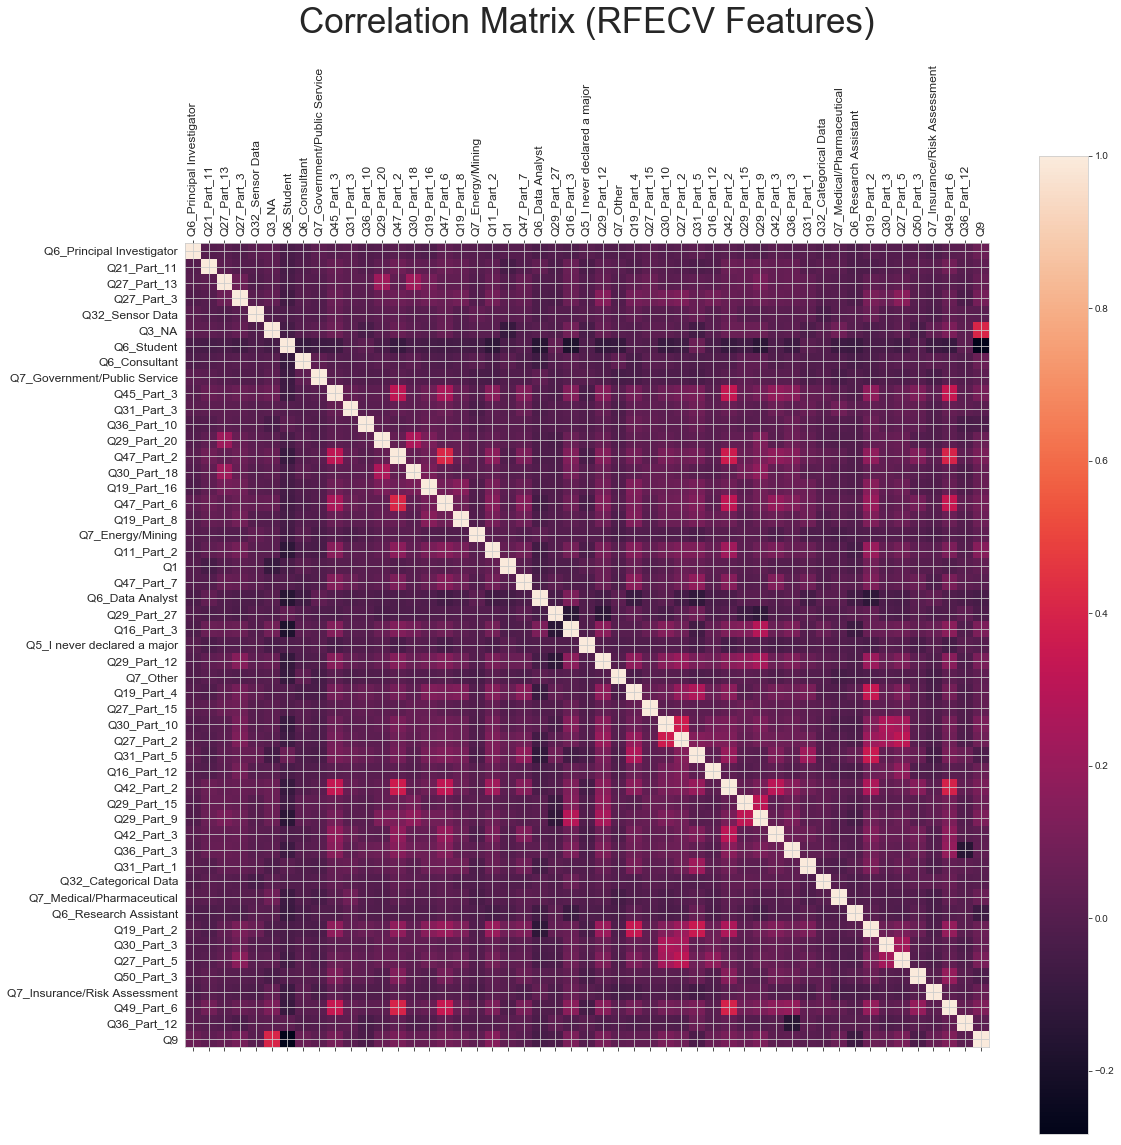

In [491]:
fig_c, ax_c = plt.subplots(figsize=(18, 18))
corr = k_corr.corr()
ax_c.matshow(corr)
ax_c.set_title('Correlation Matrix (RFECV Features)', fontsize=35, pad=170)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
ax_c.tick_params(axis='x', labelsize = 12, labelrotation = 90)
ax_c.tick_params(axis='y', labelsize = 12)
fig_c.colorbar(ax.matshow(corr))

# 6. Model Implementation

## 6.1 Model 1 - Linear Regression

* Basics: also known as "Ordinary Least Squares" (OLS), the model assumes the dependent variable is a linear function of the independent variables. I then seeks to minimize the residual sum of squares between observed responses and predictions derived from a linear function approximation that tries to fit all the data. 
    * Pros:
        1. Easy to implement, analyze and interpret, as it is based on linear algebra. 
        2. Efficient to compute; it can be quickly applied to large datasets. 
    * Cons:
        1. Multicollinearity: coefficient estimates rely on the independence of model terms; highly-correlated terms with a linear dependence make cause random errors or a large variace. 
        2. May perform badly with outliers due to how they distort squared error amounts. 
        
The method was selected due to its ease in implementation and interpretation as well as its ability to handle very large datasets. 


In [419]:
linear_R = LinearRegression()
run_kfold(linear_R, rfe_l)

Fold 1 accuracy: 0.252975760906776
Fold 2 accuracy: 0.2683175738168121
Fold 3 accuracy: 0.22921905948279953
Fold 4 accuracy: 0.297073935301281
Fold 5 accuracy: 0.302050989934173
Fold 6 accuracy: 0.2755334878815666
Fold 7 accuracy: 0.2535044140031051
Fold 8 accuracy: 0.317962509493699
Fold 9 accuracy: 0.3047983639725199
Fold 10 accuracy: 0.2518500703094828
Mean R^2: 0.2753286165102215
R^2 Standard Deviation: 0.02752368983029926
Root Mean Square Error: 52094.01183240188


### Linear Regression - KFold Results
* Fold 1 accuracy: 0.252975760906776
* Fold 2 accuracy: 0.2683175738168121
* Fold 3 accuracy: 0.22921905948279953
* Fold 4 accuracy: 0.297073935301281
* Fold 5 accuracy: 0.302050989934173
* Fold 6 accuracy: 0.2755334878815666
* Fold 7 accuracy: 0.2535044140031051
* Fold 8 accuracy: 0.317962509493699
* Fold 9 accuracy: 0.3047983639725199
* Fold 10 accuracy: 0.2518500703094828
_________________________________________
* Mean r2: 0.2753286165102215

* Standard Deviation: 0.02752368983029926

* Root Mean Square Error: 52094.01183240188

## 6.2 Model 2 - KNN
* Basics: non-parametric method for supervised and unsupervised machine learning; it tries to minimize the distance between a specific amount of data points with a similar lable. In the case of regression, the label for each point is computed based on the mean of the labels of its nearest neighbors. 
    * Pros:
        1. Simple to understand and implement. 
        2. As it only has a single hyperparameter, it is relatively simple to optimize the model. 
        3. Flexibility in the types of distance between data points to use when building the model. 
    * Cons:
        1. It slows down considerably as the dataset grows. 
        2. Requires homogenous features witht he same scale.
        3. Sensible to outlier. 
        4. No way of dealing with missing values. 
The model was selected due to its single hyperparameter (which allowed for more time for experimentation). 

In [420]:
knn = KNeighborsRegressor(n_neighbors = 25)
run_kfold(knn, rfe_l)

Fold 1 accuracy: 0.19974827187373878
Fold 2 accuracy: 0.23212808238807903
Fold 3 accuracy: 0.18659615346262937
Fold 4 accuracy: 0.224406269189254
Fold 5 accuracy: 0.25652187174806895
Fold 6 accuracy: 0.23030019755548659
Fold 7 accuracy: 0.22521169340449032
Fold 8 accuracy: 0.2573633828920455
Fold 9 accuracy: 0.27912586007221907
Fold 10 accuracy: 0.18571943026576831
Mean R^2: 0.22771212128517798
R^2 Standard Deviation: 0.02937998809483602
Root Mean Square Error: 53773.657653322254


### KNN (n=25) - KFold Results
* Fold 1 accuracy: 0.19974827187373878
* Fold 2 accuracy: 0.23212808238807903
* Fold 3 accuracy: 0.18659615346262937
* Fold 4 accuracy: 0.224406269189254
* Fold 5 accuracy: 0.25652187174806895
* Fold 6 accuracy: 0.23030019755548659
* Fold 7 accuracy: 0.22521169340449032
* Fold 8 accuracy: 0.2573633828920455
* Fold 9 accuracy: 0.27912586007221907
* Fold 10 accuracy: 0.18571943026576831
_________________________________________
* Mean r2: 0.22771212128517798

* Standard Deviation: 0.02937998809483602

* Variance: 53773.657653322254

## 6.3 Model 3 - Decision Tree
* Basics: non-parametric, supervised machine learning method that predicts the value of a target variable through decision rules (if-then-else statements) dervied from the dataset's features. 
    * Pros: 
        1. Easy to explain: situations and results applied to the model can be describe through boolean logic.
        2. Can handle numerical and categorical data
        3. Does not require as much data preparation.
    * Cons:
        1. Prone to overfitting (which can be avoided by setting a maximum depth to the tree or setting a minimum number of sample per leaf node. 
        2. Unstable towards even small variations in the data can lead to completely different trees. 
        
The model was chosen due to its ease of use with multiple data types as well as its potential simplicity in describing the salary prediction.

In [421]:
d_R = DecisionTreeRegressor()
run_kfold(d_R, rfe_l)

Fold 1 accuracy: -0.23646502669497527
Fold 2 accuracy: -0.5028557125118192
Fold 3 accuracy: -0.1827407985911793
Fold 4 accuracy: -0.20671885143926705
Fold 5 accuracy: -0.4519596550030365
Fold 6 accuracy: -0.2746873936550167
Fold 7 accuracy: -0.3209334973203475
Fold 8 accuracy: -0.5503004007816203
Fold 9 accuracy: -0.2691116954099575
Fold 10 accuracy: -0.42543326313444396
Mean R^2: -0.3421206294541664
R^2 Standard Deviation: 0.12385689696515116
Root Mean Square Error: 70671.90478206167


### Decision Tree - KFold Results

* Fold 1 accuracy: -0.23646502669497527
* Fold 2 accuracy: -0.5028557125118192
* Fold 3 accuracy: -0.1827407985911793
* Fold 4 accuracy: -0.20671885143926705
* Fold 5 accuracy: -0.4519596550030365
* Fold 6 accuracy: -0.2746873936550167
* Fold 7 accuracy: -0.3209334973203475
* Fold 8 accuracy: -0.5503004007816203
* Fold 9 accuracy: -0.2691116954099575
* Fold 10 accuracy: -0.42543326313444396
_________________________________________
* Mean r2: -0.3421206294541664

* Standard Deviation: 0.12385689696515116

* Root Mean Square Error: 70671.90478206167

## 6.4 Model 4 - Random Forest
* Basics: estimator that fits a number of classifying decision trees on various, random sub-samples of the dataset. It then gets an average of the tree's predictions to improve overall predictive accuracy and reduce over-fitting. 
    * Pros:
        1. Fast and scalable.
        2. It can model non-linear concepts. 
        3. Can be used to derive variable importance. 
        4. It does not require feature scaling or normalization. 
    * Cons: 
        1. Noisy data may cause overfitting.
        2. Results are more difficult to intepret compared to single decision trees. 
        3. Hyperparameters need to be tuned extensively for best results. 
Random Forest was selected because of its notoriety as one of the most accurate decision models. It was also considered apt to deal with our clean data without the fear of over-fitting. 

In [422]:
r_FR = RandomForestRegressor()
run_kfold(r_FR, rfe_l)

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fold 1 accuracy: 0.1333370399663898
Fold 2 accuracy: 0.0868865278436054
Fold 3 accuracy: 0.16543180246117328
Fold 4 accuracy: 0.16145003778546263
Fold 5 accuracy: 0.13624122687260742
Fold 6 accuracy: 0.1637980086343397
Fold 7 accuracy: 0.14558861121397604
Fold 8 accuracy: 0.12631097598008567
Fold 9 accuracy: 0.17643895777048646
Fold 10 accuracy: 0.10001083646091513
Mean R^2: 0.13954940249890416
R^2 Standard Deviation: 0.02774222893986102
Root Mean Square Error: 56710.585552350756


### Random Forest Regressor - KFold Results

* Fold 1 accuracy: 0.1333370399663898
* Fold 2 accuracy: 0.0868865278436054
* Fold 3 accuracy: 0.16543180246117328
* Fold 4 accuracy: 0.16145003778546263
* Fold 5 accuracy: 0.13624122687260742
* Fold 6 accuracy: 0.1637980086343397
* Fold 7 accuracy: 0.14558861121397604
* Fold 8 accuracy: 0.12631097598008567
* Fold 9 accuracy: 0.17643895777048646
* Fold 10 accuracy: 0.10001083646091513
_________________________________________
* Mean r2: 0.1395494024989041

* Standard Deviation: 0.02774222893986102

* Root Mean Square Error: 56710.585552350

## 6.5 Bonus Model: Neural Network
* Basics
    * Pros:
        1. Trains and updates the model's parameters iteratively at each step
        2. Works well with nonlinear, dense numeric arrays of floating point values. 
        3. Flexible: neural networks can be used for regression or classification problems. 
        4. Reliable for datasets with a large number of features. 
    * Cons: 
        1. Processing-heavy and computationally expensive, which makes it slow to run on smaller devices (at least during the training stage).
        2. Difficult to look under the hood and know which independent variable is influencing the depedent variables the most.
        3. Depend a lot on training data, which may cause over-fitting. 
        
The model was selected due to its prowess with datasets like our dummies DataFrame - numerical and with many data points         

In [423]:
mlp_R = MLPRegressor()

run_kfold(mlp_R, rfe_l)

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 1 accuracy: 0.02316014900827945


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 2 accuracy: 0.06599282807690798


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 3 accuracy: 0.028146976143421543


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 4 accuracy: 0.06763634208009328


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 5 accuracy: 0.07661650238393514


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 6 accuracy: 0.06674659430959273


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 7 accuracy: 0.05461033250600844


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 8 accuracy: 0.06975935797161525


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 9 accuracy: 0.06729411881086145
Fold 10 accuracy: 0.07289214091808727
Mean R^2: 0.05928553422088025
R^2 Standard Deviation: 0.017681183732359187
Root Mean Square Error: 59337.30165832789


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Neural Network - KFold Results
* Fold 1 accuracy: 0.02316014900827945(*)
* Fold 2 accuracy: 0.06599282807690798(*)
* Fold 3 accuracy: 0.028146976143421543(*)
* Fold 4 accuracy: 0.06763634208009328(*)
* Fold 5 accuracy: 0.07661650238393514(*)
* Fold 6 accuracy: 0.06674659430959273(*)
* Fold 7 accuracy: 0.05461033250600844(*)
* Fold 8 accuracy: 0.06975935797161525(*)
* Fold 9 accuracy: 0.06729411881086145
* Fold 10 accuracy: 0.07289214091808727
_________________________________________
* Mean r2: 0.05928553422088025

* Standard Deviation: 0.017681183732359187

* Root Mean Square Error: 59337.30165832789

*(*) Note: the model did not reach convergence before reaching the maximum number of default iterations (n = 200)* 

# 7. Model Tuning

## 7.1 Model 1. Linear Regression

**Note:** Linear regression models do not have hyperparameters to optimize via gridsearch. Hence, the model was left as show in its original implementation above. 

## 7.2 Model 2. KNN - Gridsearch

In [406]:
#Commented out due to long processing times
"""
knn2 = KNeighborsRegressor()

param = {'n_neighbors': np.arange(1, 150)}

knn_gscv = GridSearchCV(knn2, param, cv=10)

knn_gscv.fit(k_X[rfe_l], k_Y)
"""

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([  1,   2, ..., 148, 149])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### KNN - Gridsearch Results
* Model with rank: 1
    * Mean validation score: 0.233 (std: 0.030)
    * Parameters: {'n_neighbors': 55}

* Model with rank: 2
    * Mean validation score: 0.233 (std: 0.029)
    * Parameters: {'n_neighbors': 44}

* Model with rank: 3
    * Mean validation score: 0.233 (std: 0.028)
    * Parameters: {'n_neighbors': 62}

In [408]:
#report(knn_gscv.cv_results_)

Model with rank: 1
Mean validation score: 0.233 (std: 0.030)
Parameters: {'n_neighbors': 55}

Model with rank: 2
Mean validation score: 0.233 (std: 0.029)
Parameters: {'n_neighbors': 44}

Model with rank: 3
Mean validation score: 0.233 (std: 0.028)
Parameters: {'n_neighbors': 62}



### Optimal KNN 

In [424]:
knn_Opt = KNeighborsRegressor(n_neighbors = 55)
run_kfold(knn_Opt, rfe_l)

Fold 1 accuracy: 0.2067786688244294
Fold 2 accuracy: 0.22903171138100775
Fold 3 accuracy: 0.18063749682035868
Fold 4 accuracy: 0.23162097355392397
Fold 5 accuracy: 0.26902133278585827
Fold 6 accuracy: 0.23175308593769117
Fold 7 accuracy: 0.23027343696318325
Fold 8 accuracy: 0.26248190937936355
Fold 9 accuracy: 0.2840806489687333
Fold 10 accuracy: 0.20866237429132706
Mean R^2: 0.23343416389058763
R^2 Standard Deviation: 0.029702550487656913
Root Mean Square Error: 53580.686514008


### Optimal KNN - Results
* Fold 1 accuracy: 0.2067786688244294
* Fold 2 accuracy: 0.22903171138100775
* Fold 3 accuracy: 0.18063749682035868
* Fold 4 accuracy: 0.23162097355392397
* Fold 5 accuracy: 0.26902133278585827
* Fold 6 accuracy: 0.23175308593769117
* Fold 7 accuracy: 0.23027343696318325
* Fold 8 accuracy: 0.26248190937936355
* Fold 9 accuracy: 0.2840806489687333
* Fold 10 accuracy: 0.20866237429132706
_________________________________________
* Mean r2: 0.23343416389058763

* Standard Deviation: 0.029702550487656913

* Root Mean Square Error: 53580.686514008

## 7.3 Model 3. Decision Tree - Gridsearch

In [407]:
#Commented out due to long processing times
"""
d_R_2 = DecisionTreeRegressor()

d_R_params = {"criterion": ["mse" , "friedman_mse", "mae"],
              "min_samples_split": [20, 40, 80, 100],
              "max_depth": [None, 2, 5],
              "min_samples_leaf": [20, 40, 80, 100],
              "max_leaf_nodes": [None, 5, 10, 20],
              'max_features': np.arange(1,6,1)
              }

d_R_gscv = GridSearchCV(d_R_2, d_R_params, cv=10)

d_R_gscv.fit(k_X[rfe_l], k_Y)
"""

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['mse', 'friedman_mse', 'mae'], 'min_samples_split': [20, 40, 80, 100], 'max_depth': [None, 2, 5], 'min_samples_leaf': [20, 40, 80, 100], 'max_leaf_nodes': [None, 5, 10, 20], 'max_features': array([1, 2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [409]:
#report(d_R_gscv.cv_results_)

Model with rank: 1
Mean validation score: 0.207 (std: 0.049)
Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 40, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.200 (std: 0.056)
Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 100}

Model with rank: 3
Mean validation score: 0.190 (std: 0.053)
Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 20}



### Decision Tree - Gridsearch Results

* Model with rank: 1
    * Mean validation score: 0.207 (std: 0.049)
    * Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 40, 'min_samples_split': 20}

* Model with rank: 2
    * Mean validation score: 0.200 (std: 0.056)
    * Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 100}

* Model with rank: 3
    * Mean validation score: 0.190 (std: 0.053)
    * Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 20}

### Optimal Decision Tree

In [425]:
d_R_Opt = DecisionTreeRegressor(criterion='mse', max_depth = None, 
                                max_features= 5, max_leaf_nodes= None, 
                                min_samples_leaf= 40, min_samples_split= 20)
run_kfold(d_R_Opt, rfe_l)

Fold 1 accuracy: 0.11380716980308447
Fold 2 accuracy: 0.1558409790805253
Fold 3 accuracy: 0.14552120777089295
Fold 4 accuracy: 0.1261096642051075
Fold 5 accuracy: 0.24749070826155783
Fold 6 accuracy: 0.18725037393625377
Fold 7 accuracy: 0.18245379368189907
Fold 8 accuracy: 0.26036369366529255
Fold 9 accuracy: 0.21154010069322127
Fold 10 accuracy: 0.22674129640011764
Mean R^2: 0.18571189874979524
R^2 Standard Deviation: 0.04794088163705076
Root Mean Square Error: 55218.55247042507


### Optimal Decision Tree - Results
* Fold 1 accuracy: 0.11380716980308447
* Fold 2 accuracy: 0.1558409790805253
* Fold 3 accuracy: 0.14552120777089295
* Fold 4 accuracy: 0.1261096642051075
* Fold 5 accuracy: 0.24749070826155783
* Fold 6 accuracy: 0.18725037393625377
* Fold 7 accuracy: 0.18245379368189907
* Fold 8 accuracy: 0.26036369366529255
* Fold 9 accuracy: 0.21154010069322127
* Fold 10 accuracy: 0.22674129640011764
_________________________________________
* Mean r2: 0.18571189874979524

* Standard Deviation: 0.04794088163705076

* Root Mean Square Error: 55218.55247042507

## 7.4 Model 4. Random Forest - Gridsearch

In [410]:
#Commented out due to long processing times. 
"""
r_FR_params =  {'n_estimators': [int(x) for x in np.arange(10,200,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)] + [None],
                      'min_samples_split': [2,5,10],
                      'min_samples_leaf': [1,2,4],
                      'bootstrap': [True,False]
                      }

r_FR_2 = RandomForestRegressor()

r_FR_gscv = GridSearchCV(r_FR_2, r_FR_params, cv=10)

r_FR_gscv.fit(k_X[rfe_l], k_Y)

""""

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 2, 3, 4, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [411]:
#report(r_FR_gscv.cv_results_)

Model with rank: 1
Mean validation score: 0.290 (std: 0.025)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 190}

Model with rank: 2
Mean validation score: 0.290 (std: 0.027)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 90}

Model with rank: 3
Mean validation score: 0.290 (std: 0.025)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 190}



### Decision Forest - Gridsearch Results

* Model with rank: 1
    * Mean validation score: 0.290 (std: 0.025)
    * Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 190}

* Model with rank: 2
    * Mean validation score: 0.290 (std: 0.027)
    * Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 90}

* Model with rank: 3
    * Mean validation score: 0.290 (std: 0.025)
    * Parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 190}

### Optimal Random Forest

In [426]:
r_FR_Opt = RandomForestRegressor(bootstrap = True, max_depth=None, max_features="sqrt", 
                                 min_samples_leaf=2, min_samples_split=5, n_estimators= 190)
run_kfold(r_FR_Opt, rfe_l)

Fold 1 accuracy: 0.2684400228194562
Fold 2 accuracy: 0.284653603369877
Fold 3 accuracy: 0.24660262082554552
Fold 4 accuracy: 0.3004114906034028
Fold 5 accuracy: 0.3134764588061485
Fold 6 accuracy: 0.29045115842619085
Fold 7 accuracy: 0.27831020824332164
Fold 8 accuracy: 0.3230350068450897
Fold 9 accuracy: 0.31553918923386215
Fold 10 accuracy: 0.26711131475184513
Mean R^2: 0.288803107392474
R^2 Standard Deviation: 0.023294367085827494
Root Mean Square Error: 51604.64092564549


### Optimal Random Forest - Results
* Fold 1 accuracy: 0.2684400228194562
* Fold 2 accuracy: 0.284653603369877
* Fold 3 accuracy: 0.24660262082554552
* Fold 4 accuracy: 0.3004114906034028
* Fold 5 accuracy: 0.3134764588061485
* Fold 6 accuracy: 0.29045115842619085
* Fold 7 accuracy: 0.27831020824332164
* Fold 8 accuracy: 0.3230350068450897
* Fold 9 accuracy: 0.31553918923386215
* Fold 10 accuracy: 0.26711131475184513
_________________________________________
* Mean r2: 0.288803107392474

* Standard Deviation: 0.023294367085827494

* Root Mean Square Error: 51604.64092564549

## 7. 5 Bonus: Neural Network - Gridsearch

In [256]:
#Commented out due to long processing times. 
"""
mlp_R_param = {'hidden_layer_sizes': [i for i in range(1,15)],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'learning_rate_init': [0.001],
              'max_iter': [i for i in range(200, 1600, 200)]
              }

mlp_R = MLPRegressor()

mlp_R_gscv = GridSearchCV(mlp_R, mlp_R_param, cv=5)

mlp_R_gscv.fit(k_X[rfe_l], k_Y)
"""

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached a

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached an

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reache

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'learning_rate_init': [0.001], 'max_iter': [200, 400, 600, 800, 1000, 1200, 1400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [257]:
report(mlp_R_gscv.cv_results_)

Model with rank: 1
Mean validation score: 0.195 (std: 0.014)
Parameters: {'hidden_layer_sizes': 13, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1400}

Model with rank: 2
Mean validation score: 0.194 (std: 0.015)
Parameters: {'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1400}

Model with rank: 3
Mean validation score: 0.194 (std: 0.010)
Parameters: {'hidden_layer_sizes': 14, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1400}



### Neural Networks - Gridsearch Results

* Model with rank: 1
    * Mean validation score: 0.195 (std: 0.014)
    * Parameters: {'hidden_layer_sizes': 13, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1400}

* Model with rank: 2
    * Mean validation score: 0.194 (std: 0.015)
    * Parameters: {'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1400

* Model with rank: 3
    * Mean validation score: 0.194 (std: 0.010)
    * Parameters: {'hidden_layer_sizes': 14, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1400}

### Optimal Neural Network

In [427]:
mlp_R_Opt = MLPRegressor(hidden_layer_sizes=13, learning_rate='invscaling', 
                         learning_rate_init= 0.001, max_iter=1400)

run_kfold(mlp_R_Opt, rfe_l)

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 1 accuracy: 0.20274090744039297


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 2 accuracy: 0.22237307924831806


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 3 accuracy: 0.12387310090047732


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 4 accuracy: 0.2226473984389994


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 5 accuracy: 0.24872511991519763


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 6 accuracy: 0.21813674784011172


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 7 accuracy: 0.17210283737889231


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 8 accuracy: 0.2238043455456864


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 9 accuracy: 0.19987459902888438
Fold 10 accuracy: 0.22181463884730968
Mean R^2: 0.205609277458427
R^2 Standard Deviation: 0.0332046810114645
Root Mean Square Error: 54544.523508779625


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Optimal Neural Network - Results (*)
* Fold 1 accuracy: 0.20274090744039297
* Fold 2 accuracy: 0.22237307924831806
* Fold 3 accuracy: 0.12387310090047732
* Fold 4 accuracy: 0.2226473984389994
* Fold 5 accuracy: 0.24872511991519763
* Fold 6 accuracy: 0.21813674784011172
* Fold 7 accuracy: 0.17210283737889231
* Fold 8 accuracy: 0.2238043455456864
* Fold 9 accuracy: 0.19987459902888438
* Fold 10 accuracy: 0.22181463884730968
_________________________________________
* Mean R^2: 0.205609277458427

* R^2 Standard Deviation: 0.0332046810114645

* Root Mean Square Error: 54544.523508779625

*(*) Note: the model did not reach convergence before reaching the maximum number of iterations (n = 1400)* 

# 8. Model Results, Optimal Prediction & Discussion

## 8.1 Model Comparison Results

As seen below, the model with the best performance - according to its mean R^2 - is the **Optimized Random Forest**. 

The Random Forest algorithm ran our data through multiple decision trees whose output was combined as an average. With our specified hyperparameters, the algorithm implemented the following attributes:
* n_estimators = 19 (number of decision trees in our "forest")
* max_depth = None (our trees have no max depth, so the nodes will keep expanding until all leaves are pure or they contain less than the minimum number of samples per split)
* min__samples_leaf = 2 (each node required a minimum of 2 samples to be a leaf)
* max_features = "sqrt" (the number of features the algorithm will consider for the best split will be equal to the square root of our total number of features)
* bootstrap = True (bootstrap samples are used when building the trees as opposed to the whole dataset to prevent over-fitting. 
* min_samples_split=5 (minimum number of samples required to split an internal node).

| Model                    | Optimized (Y/N) | R^2 - Mean | R^2 - Standard Deviation |   RMSE   |
|--------------------------|:---------------:|:----------:|:------------------------:|:--------:|
| Linear Regression        |       N/A       |   0.27533  |          0.02752         | 52094.01 |
| KNN                      |        N        |   0.22771  |          0.02938         | 53773.66 |
| KNN                      |        Y        |   0.23343  |          0.0297          | 53580.69 |
| Decision Tree Regressor  |        N        |  -0.34212  |          0.12386         |  70671.9 |
| Decision Tree  Regressor |        Y        |   0.18571  |          0.04794         | 55218.55 |
| Random Forest            |        N        |   0.13955  |          0.02774         | 56710.58 |
| Random Forest            |        Y        |   0.2888   |          0.02329         | 51604.64 |
| Neural Network           |        N        |   0.05928  |          0.01768         |  59337.3 |
| Neural Network           |        Y        |   0.2056   |          0.0332          | 54544.52 |

## 8.2 Optimal Model Predictions

In [444]:
r_FR_Opt2 = RandomForestRegressor(bootstrap = True, max_depth=None, max_features="sqrt", 
                                 min_samples_leaf=2, min_samples_split=5, n_estimators= 190)

run_kfold(r_FR_Opt2, rfe_l)

Fold 1 accuracy: 0.2668476391241136
Fold 2 accuracy: 0.2843902498368218
Fold 3 accuracy: 0.241888655287808
Fold 4 accuracy: 0.29917749109464953
Fold 5 accuracy: 0.3189290023376635
Fold 6 accuracy: 0.28708874551433117
Fold 7 accuracy: 0.27322559184204964
Fold 8 accuracy: 0.32437467431817046
Fold 9 accuracy: 0.31443665428920764
Fold 10 accuracy: 0.2610389955282184
Mean R^2: 0.28713976991730333
R^2 Standard Deviation: 0.025746594372646908
Root Mean Square Error: 51667.57654645351


### Training Data Predictions

In [457]:
train_predictions = r_FR_Opt2.predict(k_X[rfe_l])
train_pred_Series = pd.Series(train_predictions.tolist())

train_pred_results = pd.DataFrame(data=k_Y)
train_pred_results["Prediction"] = train_predictions
train_pred_results["Bias"] = train_pred_results.apply(lambda row: np.mean((row.Prediction - row.Q9)**2), axis=1)
train_pred_mean = np.mean(train_pred_results["Prediction"])
train_pred_results["Variance"] = train_pred_results.apply(lambda row: np.mean((row.Prediction - train_pred_mean)**2), axis=1)

train_accuracy = r2_score(k_Y, train_predictions)
train_rmse = np.sqrt(mean_squared_error(k_Y, train_predictions))
train_mean_variance = train_pred_results["Variance"].mean()
train_mean_bias = train_pred_results["Bias"].mean()
print("R^2: ", train_accuracy)
print("RMSE: ", train_rmse)
print("Variance: ", train_mean_variance)
print("Bias: ", train_mean_bias)

R^2:  0.46587266603842514
RMSE:  44772.98749847719
Variance:  1060034929.2110676
Bias:  2004620409.538786


### Test Data Predictions

In [458]:
test_predictions = r_FR_Opt2.predict(k_X_Test[rfe_l])
test_pred_Series = pd.Series(test_predictions.tolist())

test_pred_results = pd.DataFrame(data=k_Y_Test)
test_pred_results["Prediction"] = test_predictions
test_pred_results["Bias"] = test_pred_results.apply(lambda row: np.mean((row.Prediction- row.Q9)**2), axis=1)
test_pred_mean = np.mean(test_pred_results["Prediction"])
test_pred_results["Variance"] = test_pred_results.apply(lambda row: np.mean((row.Prediction - pred_mean)**2), axis=1)

test_accuracy = r2_score(k_Y_Test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(k_Y_Test, test_predictions))

test_mean_variance = test_pred_results["Variance"].mean()
test_mean_bias = test_pred_results["Bias"].mean()

print("R^2: ", test_accuracy)
print("RMSE: ", test_rmse)
print("Variance: ", test_mean_variance)
print("Bias: ", test_mean_bias)

R^2:  0.3087548273354901
RMSE:  49860.431977704044
Variance:  948667146.5110315
Bias:  2486062677.0032597


| Dataset  |   R^2   |   RSME   |    Variance   | Bias           |
|----------|:-------:|:--------:|:-------------:|----------------|
| Training | 0.46587 | 44772.99 | 1060034929.21 | 2004620409.54  |
| Test     | 0.30875 | 49860.43 | 948667146.51  | 2486062677.003 |

## 8.3 Discussion
When applied to salary prediction, our model showed a better performance with the training data - probably due to how the training data was used to fit the initial instance of the model. 

With the training data, our model is able to predict 46% of the dataset's variability, with a root mean square error of *44,772.99* - a little under the dataset's mean salary of 50,149. Our error implies a high bias, since it has failed to fit the training data. 

There is also not a very big gap between both set's RSME values, so we could infer that our error curves are close to converging which would in turn indicate a case of low variance. Together with the issue of high bias, our low variance implies our model has under-fitted our dataset. 

Looking forward:
* Adding more rows to the training data is unlikely to lead to a better model, so it should be avoided. 
* We could implement a more complex learning algorithm to balance variance and bias. 
* Increasing the number of features and testing different subsets from the RFECV results (or trying a different method, like PCA) could also lower bias. 
* Finally, we can decrease the regularization of our current algorithm to help the it fit the data better and so increase our variance and decrease the bias. 

# 9. Sources
1. https://scikit-learn.org/stable/modules/tree.html#tree-regression
2. https://scikit-learn.org/stable/modules/linear_model.html
3. https://scikit-learn.org/stable/modules/neighbors.html#regression
4. https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
5. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
6. https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788397872/1/ch01lvl1sec27/pros-and-cons-of-neural-networks
